# Project: Unsupervised learning

## Programming project: patient clustering

In this project, you have to cluster patients that enter an ICU (Intensive Care Unit) by the features that are known on the very first day. At the end, we will check if these groups of patients have similar outcome results, in terms of length of stay or probability of death.

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of mimic_unsupervised_features.csv correponds to one ICU stay (hadm_id+icustay_id) of one patient (subject_id). Most columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at mimic_patient_metadata.csv.

Note that the main cause/disease of patient contidition is embedded as a code at ICD9_diagnosis column. The meaning of this code can be found at MIMIC_metadata_diagnose.csv. But this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at extra_data/MIMIC_diagnoses.csv.

Additionally, the file mimic_unsupervised_response.csv contains the outcome of the patients visit to the ICU, did they die and how many days were they in the ICU for. We will use this to evaluate the clusters we produce.

Main tasks are:

+ Using mimic_unsupervised_features.csv file to cluster patient stays .
+ Using mimic_unsupervised_response.csv, check if resulting clusters are related to outcomes of patients, such as length of stay, mortality or assigned ICU.

You can follow these steps for your implementation:

1. Explore and understand the dataset.

2. For your first implmentation
    
    i). Remove all non numeric columns (e.g ID's, dates and categories)

    ii). Standardise the data to have 0 column means and variance 1

    iii). Cluster the data using either K-means or spectral clustering. Show how you decided how many clusters to use

3. Then use the single valued decomposition (SVD) to reduce the dimensionality of the numerical feature space. Show how you decided how many dimensions to use. See how this affects your clustering

4. Manage the date variables e.g. try to create an Age variable, and manage categorial features e.g. create dummy variables for relevant categorical features. See how this affects your clustering

5. Consider how to incorporate the comorbidity information.

6. Explore relationship between clusters and outcomes of patients

Feel free to reduce the dataset if you experience computational constraints. As a bonus, explore if adding as an input feature the cluster label would improve a prediction model of mortality (e.g. try with LogisticRegression, or any non-linear model of your choice).


## Main criteria for grading – In Class
With weights for In-Class:
+ Code runs - 20%
+ Data preparation - 20%
+ Clustering algorithm used - 25%
+ Reasonable selection of number of clusters demonstrated - 25% 
+ SVD used - 5%
+ Reasonable selection of number of dimensions - 5%
+ Good exploration of relation between clusters and patient outcomes - 0%
+ Neat and understandable code, with some titles and comments - 0%
+ Improved methods from what we discussed in class (properly explained/justified) - 0%

# General Set-up and Data Preparation

In [1]:
#we import all at the beginning so it's easier to see which packages are used by this notebook

#importing relevant packages
import pandas as pd
%matplotlib inline
# This is a Python module that contains plotting commands
import matplotlib.pyplot as plt
# the following provides further tools for plotting with dfs
import seaborn as sns 
from scipy.stats import skew 
from sklearn.metrics import confusion_matrix
import numpy as np

#import auxiliar functions
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(os.path.dirname(currentdir))
sys.path.insert(1, parentdir)
from utils.helper_functions import plot_confusion_matrix, get_auc

#import packages related to model fitting
from sklearn.linear_model import LinearRegression, LogisticRegression

#import package to save models
import joblib

#import packages related to evaluating our models' accuracy/performance
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score as cvs

#importing packages that we will use in our randomized grid search
from scipy.stats import loguniform
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

#import packages relevant to preprocessing
from sklearn import preprocessing

#import packages relevant to feature transformations
from sklearn.preprocessing import PolynomialFeatures as plf

#import packages relevant to plotting
from project2_functions.my_plot import my_count_plot, my_dist_plot, my_coef_plot, my_plot_size_default, my_coef_plot_multi

#importing packages related to reweighting of probabilities
from project2_functions.my_reweight import reweight

#hyperparameter optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
# reading the main data
df = pd.read_csv("C:/Users/sssalas/OneDrive - Philippine Competition Commission/Desktop/project3/data/mimic_unsupervised/mimic_unsupervised_features")

# reading the response datasaet
response = pd.read_csv("C:/Users/sssalas/OneDrive - Philippine Competition Commission/Desktop/project3/data/mimic_unsupervised//mimic_unsupervised_response")

#reading the comorbidity dataset
comorbidity = pd.read_csv("C:/Users/sssalas/OneDrive - Philippine Competition Commission/Desktop/project3/data/mimic_unsupervised/extra_data/MIMIC_diagnoses.csv")

In [3]:
# storing originals

df_orig = df.copy()
response_orig = response.copy()
comorbidity_orig = comorbidity.copy()

In [4]:
df.head()

,Unnamed: 0,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,2178-02-06 10:35:00,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU
1,1,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,2129-02-12 22:34:00,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU
2,2,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,2125-11-17 23:04:00,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU
3,3,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,2131-01-26 08:00:00,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU
4,5,63311,180102,287519,70.0,130.0,97.951220,107.0,155.0,128.414634,...,2151-08-06 19:11:00,-51044.77754,EMERGENCY,Private,CATHOLIC,SINGLE,WHITE,LARGE GASTOINTESTINAL BLEED,5550,MICU


In [5]:
#checking data types
df.dtypes

#we observe that some are strings hence we will need to convert them to categories

Unnamed: 0          int64
subject_id          int64
hadm_id             int64
icustay_id          int64
HeartRate_Min     float64
HeartRate_Max     float64
HeartRate_Mean    float64
SysBP_Min         float64
SysBP_Max         float64
SysBP_Mean        float64
DiasBP_Min        float64
DiasBP_Max        float64
DiasBP_Mean       float64
MeanBP_Min        float64
MeanBP_Max        float64
MeanBP_Mean       float64
RespRate_Min      float64
RespRate_Max      float64
RespRate_Mean     float64
TempC_Min         float64
TempC_Max         float64
TempC_Mean        float64
SpO2_Min          float64
SpO2_Max          float64
SpO2_Mean         float64
Glucose_Min       float64
Glucose_Max       float64
Glucose_Mean      float64
GENDER             object
DOB                object
ADMITTIME          object
Diff              float64
ADMISSION_TYPE     object
INSURANCE          object
RELIGION           object
MARITAL_STATUS     object
ETHNICITY          object
DIAGNOSIS          object
ICD9_diagnos

In [6]:
#checking response df
response.head()

,Unnamed: 0,subject_id,hadm_id,icustay_id,HOSPITAL_EXPIRE_FLAG,LOS
0,0,55440,195768,228357,0,4.5761
1,1,76908,126136,221004,0,0.7582
2,2,95798,136645,296315,0,3.7626
3,3,40708,102505,245557,0,3.8734
4,5,63311,180102,287519,0,1.8490


In [7]:
#checking response df dtypes
response.dtypes

Unnamed: 0                int64
subject_id                int64
hadm_id                   int64
icustay_id                int64
HOSPITAL_EXPIRE_FLAG      int64
LOS                     float64
dtype: object

In [8]:
#checking comoribidity df
comorbidity.head()

#we observe that comorbidities of one patient are encoded in different columns
# hence we will need to make this fit to our main df later

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


In [9]:
#checking response df dtypes
comorbidity.dtypes

SUBJECT_ID      int64
HADM_ID         int64
SEQ_NUM       float64
ICD9_CODE      object
dtype: object

## Data Wrangling on Comorbidity Dataset

In [10]:
comorbidity.shape
#we see that one the data is entered in a different format 
#multiple rows corresponding to one patient

(651047, 4)

In [11]:
#grouping multiple rows of comorbidities by subject id
df_comorbidity =comorbidity.groupby('SUBJECT_ID').agg(lambda x: x.tolist())

In [12]:
df_comorbidity.head()

,HADM_ID,SEQ_NUM,ICD9_CODE
SUBJECT_ID,,,
2,"[163353, 163353, 163353]","[1.0, 2.0, 3.0]","[V3001, V053, V290]"
3,"[145834, 145834, 145834, 145834, 145834, 14583...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]","[0389, 78559, 5849, 4275, 41071, 4280, 6826, 4..."
4,"[185777, 185777, 185777, 185777, 185777, 18577...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]","[042, 1363, 7994, 2763, 7907, 5715, 04111, V09..."
5,"[178980, 178980, 178980]","[1.0, 2.0, 3.0]","[V3000, V053, V290]"
6,"[107064, 107064, 107064, 107064, 107064, 10706...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]","[40391, 4440, 9972, 2766, 2767, 2859, 2753, V1..."


In [13]:
df_comorbidity['SUBJECT_ID'] = df_comorbidity.index

In [14]:
df_comorbidity.shape

(46520, 4)

In [15]:
# we need to retain only subject IDs /observations that is in our main df

#storing the subject_ids of those in the main df
subjects = df["subject_id"]
print(subjects)

df_comorbidity = df_comorbidity[df_comorbidity['SUBJECT_ID'].isin(subjects)]

# only 17,476 our of 46,520 in the comorbidity dataset are in our main df

0        55440
1        76908
2        95798
3        40708
4        63311
         ...  
17471    28043
17472    87605
17473    47492
17474    62946
17475    82638
Name: subject_id, Length: 17476, dtype: int64


In [16]:
#we drop he columns we won't need so it's easier to see the extra data (comorbidity)
df_comorbidity = df_comorbidity.drop(["HADM_ID", "SEQ_NUM"], axis=1)

In [17]:
#creating a new column that contains the subject_id
df_comorbidity.rename(columns={'SUBJECT_ID':'subject_id_1'}, inplace=True)

In [18]:
df_comorbidity.head()

,ICD9_CODE,subject_id_1
SUBJECT_ID,,
23,"[2252, 3485, 78039, 4241, 4019, 2720, 2724, V4...",23
34,"[41071, 4280, 4254, 42731, 9971, 4260, 41401, ...",34
36,"[99831, 99811, 41511, 4538, 99672, 496, 41401,...",36
85,"[0389, 486, V4281, 23875, 42731, 41400, 3004, ...",85
109,"[40301, 486, 58281, 5855, 4254, 2762, 7100, 27...",109


In [19]:
#checking shape
df_comorbidity.shape

(13680, 2)

In [20]:
#checking data types
df_comorbidity.dtypes

ICD9_CODE       object
subject_id_1     int64
dtype: object

Concatenating main df and comorbidity df based on subject ID's

In [21]:
df = pd.merge(df, df_comorbidity, left_on='subject_id', right_on='subject_id_1', how='left').drop('subject_id_1', axis=1)

In [22]:
df.head()

,Unnamed: 0,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,ICD9_CODE
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,"[5789, 51881, 41071, 42831, 42732, 2851, 53550..."
1,1,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,"[53013, 9351, E915]"
2,2,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,"[56983, 56729, 5845, 5789, 5121, 5119, 56889, ..."
3,3,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,"[5533, 48242, 5163, 4280, 53081, 73300, 2720, ..."
4,5,63311,180102,287519,70.0,130.0,97.951220,107.0,155.0,128.414634,...,-51044.77754,EMERGENCY,Private,CATHOLIC,SINGLE,WHITE,LARGE GASTOINTESTINAL BLEED,5550,MICU,"[5550, V442, 4019, 73309, E9320, E8490, 30000,..."


In [23]:
df.shape #one column has been added, the comorbidity column
#but note we have to split the data in tha column

(17476, 41)

In [24]:
#checking if there are null values
df.isna().sum()

#there are no null values

Unnamed: 0        0
subject_id        0
hadm_id           0
icustay_id        0
HeartRate_Min     0
HeartRate_Max     0
HeartRate_Mean    0
SysBP_Min         0
SysBP_Max         0
SysBP_Mean        0
DiasBP_Min        0
DiasBP_Max        0
DiasBP_Mean       0
MeanBP_Min        0
MeanBP_Max        0
MeanBP_Mean       0
RespRate_Min      0
RespRate_Max      0
RespRate_Mean     0
TempC_Min         0
TempC_Max         0
TempC_Mean        0
SpO2_Min          0
SpO2_Max          0
SpO2_Mean         0
Glucose_Min       0
Glucose_Max       0
Glucose_Mean      0
GENDER            0
DOB               0
ADMITTIME         0
Diff              0
ADMISSION_TYPE    0
INSURANCE         0
RELIGION          0
MARITAL_STATUS    0
ETHNICITY         0
DIAGNOSIS         0
ICD9_diagnosis    0
FIRST_CAREUNIT    0
ICD9_CODE         0
dtype: int64

Splitting the last column (comorbidities) to multiple columns

In [25]:
#transforming the data type to string so we can split it to multiple columns
df['ICD9_CODE'] = df['ICD9_CODE'].astype('str')

In [26]:
df['ICD9_CODE'].dtypes

dtype('O')

In [27]:
#splitting the the comoribidity column to multiple columns
# I will retain only the first 10 comorbidities, assuming that the most crucial comorbidity are encoded
# first in the dataset
new = df['ICD9_CODE'].str.split(", ", n = 10, expand = True)
#my_split = df_comorbidity['ICD9_CODE'].str.split(', ', -1, expand=True)

In [28]:
new

,0,1,2,3,4,5,6,7,8,9,10
0,['5789','51881','41071','42831','42732','2851','53550','79092','4280','42731',"'42789', '49320', '40390', '5852', '43811', '4..."
1,['53013','9351','E915'],None,None,None,None,None,None,None,None
2,['56983','56729','5845','5789','5121','5119','56889','E8788','3310','29410',"'40390', '25002', '5859', '4465']"
3,['5533','48242','5163','4280','53081','73300','2720','4019','2440','30000',"'311', 'V1082', 'V1351', 'V4364', 'V4365', '41..."
4,['5550','V442','4019','73309','E9320','E8490','30000','V1251','42789','V160','V5865']
...,...,...,...,...,...,...,...,...,...,...,...
17471,['59971','3453','00845','2762','5650','5849','70703','70725','25000','28529',"'4019', '9092', '42731', '3530', '3559', 'V441..."
17472,['1918','3485','3484','7843','25000','36846'],None,None,None,None,None
17473,['24980','5990','E9323','4019','7140','53081','4373','78039','7140','25000','4019']
17474,['41401','42823','9972','2930','99811','4111','2851','4423','E8790','71596',"'4019', '2449', '2724']"


In [29]:
#removing unwanted characters

new[0] = new[0].str.replace("[\[\]\"']", "")
new[1] = new[1].str.replace("[\[\]\"']", "")
new[2] = new[2].str.replace("[\[\]\"']", "")
new[3] = new[3].str.replace("[\[\]\"']", "")
new[4] = new[4].str.replace("[\[\]\"']", "")
new[5] = new[5].str.replace("[\[\]\"']", "")
new[6] = new[6].str.replace("[\[\]\"']", "")
new[7] = new[7].str.replace("[\[\]\"']", "")
new[8] = new[8].str.replace("[\[\]\"']", "")
new[9] = new[9].str.replace("[\[\]\"']", "")
new[10] = new[10].str.replace("[\[\]\"']", "")

<ipython-input-29-93307a2263e2>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  new[0] = new[0].str.replace("[\[\]\"']", "")
<ipython-input-29-93307a2263e2>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  new[1] = new[1].str.replace("[\[\]\"']", "")
<ipython-input-29-93307a2263e2>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  new[2] = new[2].str.replace("[\[\]\"']", "")
<ipython-input-29-93307a2263e2>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  new[3] = new[3].str.replace("[\[\]\"']", "")
<ipython-input-29-93307a2263e2>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  new[4] = new[4].str.replace("[\[\]\"']", "")
<ipython-input-29-93307a2263e2>:8: FutureWarning: The default value of regex will change from True to False in a future 

In [30]:
new #now, we see that the brackets and quotations marks are gone

,0,1,2,3,4,5,6,7,8,9,10
0,5789,51881,41071,42831,42732,2851,53550,79092,4280,42731,"42789, 49320, 40390, 5852, 43811, 43889, 78079"
1,53013,9351,E915,None,None,None,None,None,None,None,None
2,56983,56729,5845,5789,5121,5119,56889,E8788,3310,29410,"40390, 25002, 5859, 4465"
3,5533,48242,5163,4280,53081,73300,2720,4019,2440,30000,"311, V1082, V1351, V4364, V4365, 41071, 2939, ..."
4,5550,V442,4019,73309,E9320,E8490,30000,V1251,42789,V160,V5865
...,...,...,...,...,...,...,...,...,...,...,...
17471,59971,3453,00845,2762,5650,5849,70703,70725,25000,28529,"4019, 9092, 42731, 3530, 3559, V441, V1046, V5..."
17472,1918,3485,3484,7843,25000,36846,None,None,None,None,None
17473,24980,5990,E9323,4019,7140,53081,4373,78039,7140,25000,4019
17474,41401,42823,9972,2930,99811,4111,2851,4423,E8790,71596,"4019, 2449, 2724"


In [31]:
#dropping the 11th onwards comorbidities
new = new.drop(10, axis=1)

In [32]:
#concatenating the main df and comorbidity df
df = pd.concat([df, new], axis=1)

In [33]:
df.head()

,Unnamed: 0,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,0,1,2,3,4,5,6,7,8,9
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,5789,51881,41071,42831,42732,2851,53550,79092,4280,42731
1,1,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,53013,9351,E915,None,None,None,None,None,None,None
2,2,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,56983,56729,5845,5789,5121,5119,56889,E8788,3310,29410
3,3,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,5533,48242,5163,4280,53081,73300,2720,4019,2440,30000
4,5,63311,180102,287519,70.0,130.0,97.951220,107.0,155.0,128.414634,...,5550,V442,4019,73309,E9320,E8490,30000,V1251,42789,V160


In [34]:
#renaming the columns so that the comorbidity column names are letters, not numbers

df.columns = [    'Unnamed: 0',     'subject_id',        'hadm_id',     'icustay_id',
        'HeartRate_Min',  'HeartRate_Max', 'HeartRate_Mean',      'SysBP_Min',
            'SysBP_Max',     'SysBP_Mean',     'DiasBP_Min',     'DiasBP_Max',
          'DiasBP_Mean',     'MeanBP_Min',     'MeanBP_Max',    'MeanBP_Mean',
         'RespRate_Min',   'RespRate_Max',  'RespRate_Mean',      'TempC_Min',
            'TempC_Max',     'TempC_Mean',       'SpO2_Min',       'SpO2_Max',
            'SpO2_Mean',    'Glucose_Min',    'Glucose_Max',   'Glucose_Mean',
               'GENDER',            'DOB',      'ADMITTIME',           'Diff',
       'ADMISSION_TYPE',      'INSURANCE',       'RELIGION', 'MARITAL_STATUS',
            'ETHNICITY',      'DIAGNOSIS', 'ICD9_diagnosis', 'FIRST_CAREUNIT',
            'ICD9_CODE',                'A',                'B',                'C',
                      'D',                'E',                'F',                'G',
                      'H',                'I',                'J']

In [35]:
df.columns

Index(['Unnamed: 0', 'subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Min',
       'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max',
       'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min',
       'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max',
       'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min',
       'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean',
       'GENDER', 'DOB', 'ADMITTIME', 'Diff', 'ADMISSION_TYPE', 'INSURANCE',
       'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS',
       'ICD9_diagnosis', 'FIRST_CAREUNIT', 'ICD9_CODE', 'A', 'B', 'C', 'D',
       'E', 'F', 'G', 'H', 'I', 'J'],
      dtype='object')

In [36]:
#converting the comorbidities to categorical variable
df['A'] = pd.Categorical(df.A)
df['A_code'] = df.A.cat.codes

df = df.drop(columns='A')

In [37]:
#doing the same for the rest
df['B'] = pd.Categorical(df.B)
df['B_code'] = df.B.cat.codes

df['C'] = pd.Categorical(df.C)
df['C_code'] = df.C.cat.codes

df['D'] = pd.Categorical(df.D)
df['D_code'] = df.D.cat.codes

df['E'] = pd.Categorical(df.E)
df['E_code'] = df.E.cat.codes

df['F'] = pd.Categorical(df.F)
df['F_code'] = df.F.cat.codes

df['G'] = pd.Categorical(df.G)
df['G_code'] = df.G.cat.codes

df['H'] = pd.Categorical(df.H)
df['H_code'] = df.H.cat.codes

df['I'] = pd.Categorical(df.I)
df['I_code'] = df.I.cat.codes

df['J'] = pd.Categorical(df.J)
df['J_code'] = df.J.cat.codes

#dropping the string version of the comorbidities
df = df.drop(columns=['B','C', 'D',
       'E', 'F', 'G', 'H', 'I', 'J'], axis=1)

In [38]:
df.head()

,Unnamed: 0,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,A_code,B_code,C_code,D_code,E_code,F_code,G_code,H_code,I_code,J_code
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,961,705,538,639,621,281,853,1229,555,536
1,1,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,795,1227,1597,-1,-1,-1,-1,-1,-1,-1
2,2,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,916,792,970,986,818,780,899,1521,374,286
3,3,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,868,649,791,633,856,1143,230,512,156,303
4,5,63311,180102,287519,70.0,130.0,97.951220,107.0,155.0,128.414634,...,869,1417,523,1158,1675,1575,353,1634,554,1554


In [39]:
print(len(df.A_code.unique()))

df = df.drop(columns=['D_code',
       'E_code', 'F_code', 'G_code', 'H_code', 'I_code', 'J_code'], axis=1)

#because of there are a lot of unique values of comorobidities, I will only retain the first three commorbidity columns
# and only create dummies for values the occurs frequently

1740


In [40]:
print(len(df.B_code.unique()))
print(len(df.C_code.unique()))

1447
1734


Before transforming the comorbidity categories to dummies, let first handling the dates to create an age variable

## Creating the Age Column

We create the cage column based on 'DOB' (date of birth) and 'ADMITTIME' (admit time). It is safe to just take the difference of these two values since as we have observed before, tha maximum lenght  of stay at thr hospital is around 102 days. So the patient's age is likely to have not changed much since he/she was admitted.

In [41]:
#going back to the main df, we observe that we have date columns

df[['DOB', 'ADMITTIME']]

# as we can observe the years have been adjusted to protect the identity of the patients

,DOB,ADMITTIME
0,2108-07-16 00:00:00,2178-02-06 10:35:00
1,2087-01-16 00:00:00,2129-02-12 22:34:00
2,2057-09-17 00:00:00,2125-11-17 23:04:00
3,2056-02-27 00:00:00,2131-01-26 08:00:00
4,2102-06-04 00:00:00,2151-08-06 19:11:00
...,...,...
17471,2088-12-15 00:00:00,2176-06-17 06:36:00
17472,2071-11-18 00:00:00,2137-09-27 23:14:00
17473,2055-11-27 00:00:00,2118-10-18 17:54:00
17474,1871-07-17 00:00:00,2171-07-17 21:24:00


In [42]:
#we covert the data type of these columns to datetime
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])
df['DOB'] = pd.to_datetime(df['DOB'])

In [43]:
df.dtypes

#now the two columns that we are concerned with are now in date format

Unnamed: 0                 int64
subject_id                 int64
hadm_id                    int64
icustay_id                 int64
HeartRate_Min            float64
HeartRate_Max            float64
HeartRate_Mean           float64
SysBP_Min                float64
SysBP_Max                float64
SysBP_Mean               float64
DiasBP_Min               float64
DiasBP_Max               float64
DiasBP_Mean              float64
MeanBP_Min               float64
MeanBP_Max               float64
MeanBP_Mean              float64
RespRate_Min             float64
RespRate_Max             float64
RespRate_Mean            float64
TempC_Min                float64
TempC_Max                float64
TempC_Mean               float64
SpO2_Min                 float64
SpO2_Max                 float64
SpO2_Mean                float64
Glucose_Min              float64
Glucose_Max              float64
Glucose_Mean             float64
GENDER                    object
DOB               datetime64[ns]
ADMITTIME 

In [44]:
#we get the years. it is okay to ignore the months and days since it wouldn't make much of a difference on age.

df['year_admit']= df['ADMITTIME'].dt.year

df['year_birth']= df['DOB'].dt.year

In [45]:
df[['year_admit', 'year_birth']]

,year_admit,year_birth
0,2178,2108
1,2129,2087
2,2125,2057
3,2131,2056
4,2151,2102
...,...,...
17471,2176,2088
17472,2137,2071
17473,2118,2055
17474,2171,1871


In [46]:
df['age']= df['year_admit'] - df['year_birth']

In [47]:
df[['age']]

,age
0,70
1,42
2,68
3,75
4,49
...,...
17471,88
17472,66
17473,63
17474,300


In [48]:
column = df['age']
max_value = column.max()
print(max_value)

# it is weird that there are some patients that are 300+ years of age

311


In [49]:
pd.set_option('display.max_rows', None)
df['age'].value_counts(ascending=False) 

300    705
67     429
66     424
62     418
64     414
63     397
69     397
60     387
65     385
68     378
61     377
82     363
76     357
72     354
80     351
81     350
75     346
79     342
77     341
57     339
84     332
83     330
54     329
58     328
70     328
56     327
73     324
55     320
85     315
59     314
52     313
78     311
74     310
71     289
51     284
53     282
86     277
87     268
50     241
88     217
48     207
47     201
49     198
45     197
46     180
44     152
43     142
42     137
40     135
41     132
39     116
89     115
38     110
35      89
37      86
25      86
34      84
31      79
33      78
30      77
26      77
28      72
27      71
36      68
32      67
21      64
22      63
24      62
23      62
29      60
301     48
302     46
20      40
19      37
18      26
307     20
303     18
304     18
305     16
308     14
17      12
306     11
310      3
309      3
16       2
311      1
15       1
Name: age, dtype: int64

In [50]:
df.shape

(17476, 47)

In [51]:
#lets drop observations with more than age>100
#this is likely to wrong encoding of ADMITTIME and DOB 
# but it says in the metadata that we could add the 'Diff' column to the datetime variables to make it realistic
# however, i think that it's okay if we just drop the observation with absurd ages
# as they are only a few and I want to somehow make my dataset smaller to lessen computational time

In [52]:
response['age'] = df["age"]

df = df[df.age < 100] # we only retain observations with age < 100
response = response[response.age < 100]

In [53]:
print(df.shape) # 17476 - 16573 = 903 observations have been dropped
print(response.shape)

(16573, 47)
(16573, 7)


In [54]:
df.head()

,Unnamed: 0,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,ICD9_CODE,A_code,B_code,C_code,year_admit,year_birth,age
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,GASTROINTESTINAL BLEED,5789,MICU,"['5789', '51881', '41071', '42831', '42732', '...",961,705,538,2178,2108,70
1,1,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,ESOPHAGEAL FOOD IMPACTION,53013,MICU,"['53013', '9351', 'E915']",795,1227,1597,2129,2087,42
2,2,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,UPPER GI BLEED,56983,MICU,"['56983', '56729', '5845', '5789', '5121', '51...",916,792,970,2125,2057,68
3,3,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,HIATAL HERNIA/SDA,5533,SICU,"['5533', '48242', '5163', '4280', '53081', '73...",868,649,791,2131,2056,75
4,5,63311,180102,287519,70.0,130.0,97.951220,107.0,155.0,128.414634,...,LARGE GASTOINTESTINAL BLEED,5550,MICU,"['5550', 'V442', '4019', '73309', 'E9320', 'E8...",869,1417,523,2151,2102,49


In [55]:
df['age'].value_counts(ascending=False) 
# we observe that there are no more weird values in age column

67    429
66    424
62    418
64    414
63    397
69    397
60    387
65    385
68    378
61    377
82    363
76    357
72    354
80    351
81    350
75    346
79    342
77    341
57    339
84    332
83    330
54    329
58    328
70    328
56    327
73    324
55    320
85    315
59    314
52    313
78    311
74    310
71    289
51    284
53    282
86    277
87    268
50    241
88    217
48    207
47    201
49    198
45    197
46    180
44    152
43    142
42    137
40    135
41    132
39    116
89    115
38    110
35     89
37     86
25     86
34     84
31     79
33     78
26     77
30     77
28     72
27     71
36     68
32     67
21     64
22     63
23     62
24     62
29     60
20     40
19     37
18     26
17     12
16      2
15      1
Name: age, dtype: int64

In [56]:
#more data cleaning

#drop columns which are not yet to be used
#df = df.drop(["Unnamed: 0", "subject_id", "hadm_id", "icustay_id", "DOB", "ADMITTIME", "INSURANCE", "RELIGION",	"MARITAL_STATUS",	"ETHNICITY", "FIRST_CAREUNIT", "ADMISSION_TYPE"], axis = 1)
df = df.drop(["Unnamed: 0", "subject_id", "hadm_id", "icustay_id", "DOB", "ADMITTIME",  'Diff', 'year_admit', 'year_birth', ], axis = 1)

In [57]:
#data conversion from string to categorical

df['GENDER'] = pd.Categorical(df.GENDER)
df['GENDER_code'] = df.GENDER.cat.codes
df = df.drop(columns='GENDER')
# 0 - female, 1 - male

In [58]:
#data conversion from string to cateogrical

df['ICD9_diagnosis'] = pd.Categorical(df.ICD9_diagnosis)
df['ICD9_diagnosis_code'] = df.ICD9_diagnosis.cat.codes
df = df.drop(columns='ICD9_diagnosis')
#df = df.drop(["DIAGNOSIS"], axis = 1)

df['DIAGNOSIS'] = pd.Categorical(df.DIAGNOSIS)
df['DIAGNOSIS_code'] = df.DIAGNOSIS.cat.codes
df = df.drop(columns='DIAGNOSIS')

In [59]:
#check correlation of ICD9_diagnosis and DIAGNOSIS... Are they the same?\\
corr_diagnosis = df['ICD9_diagnosis_code'].corr(df['DIAGNOSIS_code'])
print(corr_diagnosis)

#they are not the same

0.036780403916067766


In [60]:
#data conversion from string to categorical

df["INSURANCE"] = pd.Categorical(df.INSURANCE)
df["INSURANCE_code"] = df.INSURANCE.cat.codes
df = df.drop(columns="INSURANCE")

df["RELIGION"] = pd.Categorical(df.RELIGION)
df["RELIGION_code"] = df.RELIGION.cat.codes
df = df.drop(columns="RELIGION")

df["MARITAL_STATUS"] = pd.Categorical(df.MARITAL_STATUS)
df["MARITAL_STATUS_code"] = df.MARITAL_STATUS.cat.codes
df = df.drop(columns="MARITAL_STATUS")

df["ETHNICITY"] = pd.Categorical(df.ETHNICITY)
df["ETHNICITY_code"] = df.ETHNICITY.cat.codes
df = df.drop(columns="ETHNICITY")

df["FIRST_CAREUNIT"] = pd.Categorical(df.FIRST_CAREUNIT)
df["FIRST_CAREUNIT_code"] = df.FIRST_CAREUNIT.cat.codes
df = df.drop(columns="FIRST_CAREUNIT")

df["ADMISSION_TYPE"] = pd.Categorical(df.ADMISSION_TYPE)
df["ADMISSION_TYPE_code"] = df.ADMISSION_TYPE.cat.codes
df = df.drop(columns="ADMISSION_TYPE")

In [61]:
df.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,age,GENDER_code,ICD9_diagnosis_code,DIAGNOSIS_code,INSURANCE_code,RELIGION_code,MARITAL_STATUS_code,ETHNICITY_code,FIRST_CAREUNIT_code,ADMISSION_TYPE_code
0,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,...,70,0,994,2156,2,13,4,36,2,1
1,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,...,42,0,817,1900,3,16,2,36,2,1
2,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,...,68,0,946,4984,2,13,3,13,2,1
3,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,48.0,...,75,0,898,2315,2,11,6,36,3,0
4,70.0,130.0,97.951220,107.0,155.0,128.414634,60.0,88.0,74.780488,72.0,...,49,1,899,2711,3,2,4,36,2,1


In [62]:
col_names = df.columns
print(col_names)

Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'ICD9_CODE', 'A_code', 'B_code', 'C_code', 'age',
       'GENDER_code', 'ICD9_diagnosis_code', 'DIAGNOSIS_code',
       'INSURANCE_code', 'RELIGION_code', 'MARITAL_STATUS_code',
       'ETHNICITY_code', 'FIRST_CAREUNIT_code', 'ADMISSION_TYPE_code'],
      dtype='object')


In [63]:
df.dtypes

HeartRate_Min          float64
HeartRate_Max          float64
HeartRate_Mean         float64
SysBP_Min              float64
SysBP_Max              float64
SysBP_Mean             float64
DiasBP_Min             float64
DiasBP_Max             float64
DiasBP_Mean            float64
MeanBP_Min             float64
MeanBP_Max             float64
MeanBP_Mean            float64
RespRate_Min           float64
RespRate_Max           float64
RespRate_Mean          float64
TempC_Min              float64
TempC_Max              float64
TempC_Mean             float64
SpO2_Min               float64
SpO2_Max               float64
SpO2_Mean              float64
Glucose_Min            float64
Glucose_Max            float64
Glucose_Mean           float64
ICD9_CODE               object
A_code                   int16
B_code                   int16
C_code                   int16
age                      int64
GENDER_code               int8
ICD9_diagnosis_code      int16
DIAGNOSIS_code           int16
INSURANC

In [64]:
#dropping this as the comorbidities has been stored as categorical in 'A_code', 'B_code', and 'C_code' already
df = df.drop(["ICD9_CODE"], axis = 1)

## Creating dummy variables

Getting the most frequent observations to create dummies on.

First we do it for the 'ICD9_diagnosis' column, and then the 'DIAGNOSIS' column. We also do it for the comorbidity columns, 'A_code', 'B_code' and 'C_code'.

In [65]:
ICD9_diagnosis_code_stats = df['ICD9_diagnosis_code'].value_counts(ascending=False) #we count the number of unique values, sort them from highest to lowest, store the results to soil_stats

In [66]:
# we will only retain ICD9_diagnosis that occurs more than 150 times.
# There are only 15 ICD9_diagnosis that fulfill this criterion
# these are the ones we will make dummies on
len(ICD9_diagnosis_code_stats[ICD9_diagnosis_code_stats>150]) 

15

In [67]:
len(ICD9_diagnosis_code_stats[ICD9_diagnosis_code_stats<=150])

1717

In [68]:
ICD9_diagnosis_code_stats_less_than_150 = ICD9_diagnosis_code_stats[ICD9_diagnosis_code_stats<=150] #we store the neighborhoods will less than 100 obs

In [69]:
df.ICD9_diagnosis_code = df.ICD9_diagnosis_code.apply(lambda x: 'other' if x in ICD9_diagnosis_code_stats_less_than_150 else x) #we are replacing the values with 'other' for those soil types with less than 100 obs
len(df.ICD9_diagnosis_code.unique()) #now, we only have 16 unique ICD9_diagnosis_code instead of 1,732

16

In [70]:
df.ICD9_diagnosis_code.unique()

array([994, 'other', 573, 763, 550, 32, 612, 744, 543, 312, 210, 794, 596,
       611, 1001, 600], dtype=object)

Now, doing the same for 'DIAGNOSIS_code'.

In [71]:
DIAGNOSIS_code_stats = df['DIAGNOSIS_code'].value_counts(ascending=False) #we count the number of unique values, sort them from highest to lowest, store the results to soil_stats

In [72]:
len(DIAGNOSIS_code_stats[DIAGNOSIS_code_stats>150]) 

16

In [73]:
len(DIAGNOSIS_code_stats[DIAGNOSIS_code_stats<=150])

5136

In [74]:
DIAGNOSIS_code_stats_less_than_150 = DIAGNOSIS_code_stats[DIAGNOSIS_code_stats<=150] 

In [75]:
len(df.DIAGNOSIS_code.unique())

5152

In [76]:
df.DIAGNOSIS_code = df.DIAGNOSIS_code.apply(lambda x: 'other' if x in DIAGNOSIS_code_stats_less_than_150 else x) #we are replacing the values with 'other' for those soil types with less than 100 obs
len(df.DIAGNOSIS_code.unique()) #now, we only have 11 unique neighborhoodcodes instead of 39

17

In [77]:
df.DIAGNOSIS_code.unique()

array([2156, 'other', 4984, 75, 3664, 289, 2011, 4350, 1460, 2428, 1117,
       2595, 1690, 2915, 1367, 1545, 4635], dtype=object)

I will do the same to the three commorbidity columns

In [78]:
A_code_stats = df['A_code'].value_counts(ascending=False) #we count the number of unique values, sort them from highest to lowest, store the results to A_code_stats

print(len(A_code_stats[A_code_stats>150]))
print(len(A_code_stats[A_code_stats<=150]))

A_code_stats_less_than_150 = A_code_stats[A_code_stats<=150] 

df.A_code = df.A_code.apply(lambda x: 'other' if x in A_code_stats_less_than_150 else x) #we are replacing the values with 'other' for those A_code with less than 150 obs
len(df.A_code.unique())

11
1715


12

In [79]:
B_code_stats = df['B_code'].value_counts(ascending=False) #we count the number of unique values, sort them from highest to lowest, store the results to B_code_stats

print(len(B_code_stats[B_code_stats>250]))
print(len(B_code_stats[B_code_stats<=250]))

B_code_stats_less_than_250 = B_code_stats[B_code_stats<=250] 

df.B_code = df.B_code.apply(lambda x: 'other' if x in B_code_stats_less_than_250 else x) #we are replacing the values with 'other' for those soil types with less than 100 obs
len(df.B_code.unique())

# we have increased the threshold from 150 to 250 as 250 generated too many unique values

10
1412


11

In [80]:
C_code_stats = df['C_code'].value_counts(ascending=False) #we count the number of unique values, sort them from highest to lowest, store the results to soil_stats

print(len(C_code_stats[C_code_stats>250]))
print(len(C_code_stats[C_code_stats<=250]))

C_code_stats_less_than_250 = C_code_stats[C_code_stats<=250] 

df.C_code = df.C_code.apply(lambda x: 'other' if x in C_code_stats_less_than_250 else x) #we are replacing the values with 'other' for those soil types with less than 100 obs
len(df.C_code.unique())

# we have increased the threshold from 150 to 250 as 250 generated too many unique values

6
1701


7

In [81]:
print(len(df.ETHNICITY_code.unique())) #we will only create dummmies on major ethnicity, lump minorities into others
print(len(df.MARITAL_STATUS_code.unique()))
print(len(df.INSURANCE_code.unique()))
print(len(df.RELIGION_code.unique()))  #we will only create dummmies on major religions, lump minorities into others

41
7
5
17


In [82]:
ETHNICITY_code_stats = df['ETHNICITY_code'].value_counts(ascending=False) #we count the number of unique values, sort them from highest to lowest, store the results to soil_stats
print(ETHNICITY_code_stats)

print(len(ETHNICITY_code_stats[ETHNICITY_code_stats>250]))
print(len(ETHNICITY_code_stats[ETHNICITY_code_stats<=250]))

ETHNICITY_code_stats_less_than_250 = ETHNICITY_code_stats[ETHNICITY_code_stats<=250] 

df.ETHNICITY_code = df.ETHNICITY_code.apply(lambda x: 'other' if x in ETHNICITY_code_stats_less_than_250 else x) #we are replacing the values with 'other' for those soil types with less than 100 obs
len(df.ETHNICITY_code.unique())

# we have increased the threshold from 150 to 250 as 250 generated too many unique values

36    12040
13     1695
17      485
30      404
34      335
35      283
2       202
31      149
25      133
5       125
14      107
40       90
15       62
3        53
21       48
28       39
39       38
32       37
37       28
11       24
27       22
12       21
22       19
20       17
38       16
6        14
4        14
0        12
26       10
24        8
18        7
16        6
8         5
7         5
29        5
33        4
10        3
9         2
23        2
19        2
1         2
Name: ETHNICITY_code, dtype: int64
6
35


7

In [83]:
ETHNICITY_code_stats = df['ETHNICITY_code'].value_counts(ascending=False) #we count the number of unique values, sort them from highest to lowest, store the results to soil_stats
print(ETHNICITY_code_stats)

print(len(ETHNICITY_code_stats[ETHNICITY_code_stats>250]))
print(len(ETHNICITY_code_stats[ETHNICITY_code_stats<=250]))

ETHNICITY_code_stats_less_than_250 = ETHNICITY_code_stats[ETHNICITY_code_stats<=250] 

df.ETHNICITY_code = df.ETHNICITY_code.apply(lambda x: 'other' if x in ETHNICITY_code_stats_less_than_250 else x) #we are replacing the values with 'other' for those soil types with less than 100 obs
len(df.ETHNICITY_code.unique())

# we have increased the threshold from 150 to 250 as 250 generated too many unique values

36       12040
13        1695
other     1331
17         485
30         404
34         335
35         283
Name: ETHNICITY_code, dtype: int64
7
0


7

In [84]:
RELIGION_code_stats = df['RELIGION_code'].value_counts(ascending=False) #we count the number of unique values, sort them from highest to lowest, store the results to soil_stats
print(RELIGION_code_stats)

print(len(RELIGION_code_stats[RELIGION_code_stats>250]))
print(len(RELIGION_code_stats[RELIGION_code_stats<=250]))

RELIGION_code_stats_less_than_250 = RELIGION_code_stats[RELIGION_code_stats<=250] 

df.RELIGION_code = df.RELIGION_code.apply(lambda x: 'other' if x in RELIGION_code_stats_less_than_250 else x) #we are replacing the values with 'other' for those soil types with less than 100 obs
len(df.RELIGION_code.unique())

# we have increased the threshold from 150 to 250 as 250 generated too many unique values

2     6314
11    4453
13    2208
9     1262
16     944
12     550
4      231
5      142
3      141
1       91
10      68
15      40
8       40
7       32
14      29
0       27
6        1
Name: RELIGION_code, dtype: int64
6
11


7

Now, we create the dummy variables for gender, admision type and diagnoses columns. We live out other categorical variables such as religion, marital status, and ethnicity.

In [85]:
#dummy columns for gender

#df = pd.get_dummies(df, columns=['GENDER_code', 'ADMISSION_TYPE_code','ICD9_diagnosis_code', 'DIAGNOSIS_code', 'A_code', 'B_code', 'C_code'],drop_first=True)
        
df = pd.get_dummies(df, columns=['ICD9_diagnosis_code', 'DIAGNOSIS_code', 'INSURANCE_code',
       'RELIGION_code', 'MARITAL_STATUS_code', 'ETHNICITY_code',
       'FIRST_CAREUNIT_code', 'ADMISSION_TYPE_code', 'A_code', 'B_code', 'C_code'],drop_first=True)

In [86]:
df.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,B_code_855,B_code_860,B_code_1020,B_code_other,C_code_523,C_code_753,C_code_805,C_code_972,C_code_1001,C_code_other
0,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,...,0,0,0,0,0,0,0,0,0,1
1,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,...,0,0,0,1,0,0,0,0,0,1
2,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,...,0,0,0,1,0,0,0,0,0,1
3,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,48.0,...,0,0,0,1,0,0,0,0,0,1
4,70.0,130.0,97.951220,107.0,155.0,128.414634,60.0,88.0,74.780488,72.0,...,0,0,0,1,1,0,0,0,0,0


In [87]:
df.columns

Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min',
       ...
       'B_code_855', 'B_code_860', 'B_code_1020', 'B_code_other', 'C_code_523',
       'C_code_753', 'C_code_805', 'C_code_972', 'C_code_1001',
       'C_code_other'],
      dtype='object', length=112)

In [88]:
small_df = df.copy()
# I call it small df but it's not actually small

In [89]:
small_df.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,B_code_855,B_code_860,B_code_1020,B_code_other,C_code_523,C_code_753,C_code_805,C_code_972,C_code_1001,C_code_other
0,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,...,0,0,0,0,0,0,0,0,0,1
1,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,...,0,0,0,1,0,0,0,0,0,1
2,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,...,0,0,0,1,0,0,0,0,0,1
3,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,48.0,...,0,0,0,1,0,0,0,0,0,1
4,70.0,130.0,97.951220,107.0,155.0,128.414634,60.0,88.0,74.780488,72.0,...,0,0,0,1,1,0,0,0,0,0


In [90]:
small_df.describe()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,B_code_855,B_code_860,B_code_1020,B_code_other,C_code_523,C_code_753,C_code_805,C_code_972,C_code_1001,C_code_other
count,16573.000000,16573.000000,16573.000000,16573.000000,16573.000000,16573.000000,16573.000000,16573.000000,16573.000000,16573.000000,...,16573.000000,16573.000000,16573.000000,16573.000000,16573.000000,16573.000000,16573.000000,16573.000000,16573.000000,16573.000000
mean,70.080734,105.509974,85.454756,91.343148,150.653171,119.229903,44.652688,88.532191,62.874738,56.604236,...,0.065890,0.028480,0.017619,0.694201,0.024136,0.018705,0.030713,0.036807,0.020998,0.849756
std,14.727028,20.938911,15.310068,17.247138,23.612872,16.590970,11.820498,19.092269,10.928818,14.232826,...,0.248098,0.166345,0.131566,0.460759,0.153475,0.135486,0.172543,0.188293,0.143382,0.357322
min,2.000000,39.000000,34.714286,5.000000,70.000000,50.863636,4.000000,29.000000,24.625000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,91.000000,74.468750,81.000000,134.000000,107.192308,37.000000,75.000000,55.326087,50.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,69.000000,103.000000,84.392857,90.000000,148.000000,117.000000,44.000000,86.000000,61.757576,57.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,79.000000,118.000000,95.551020,101.000000,164.000000,129.454545,52.000000,98.000000,69.261905,65.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,137.000000,280.000000,149.676471,168.000000,323.000000,202.172414,103.000000,275.000000,121.489362,112.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [91]:
small_df.dtypes

HeartRate_Min                float64
HeartRate_Max                float64
HeartRate_Mean               float64
SysBP_Min                    float64
SysBP_Max                    float64
SysBP_Mean                   float64
DiasBP_Min                   float64
DiasBP_Max                   float64
DiasBP_Mean                  float64
MeanBP_Min                   float64
MeanBP_Max                   float64
MeanBP_Mean                  float64
RespRate_Min                 float64
RespRate_Max                 float64
RespRate_Mean                float64
TempC_Min                    float64
TempC_Max                    float64
TempC_Mean                   float64
SpO2_Min                     float64
SpO2_Max                     float64
SpO2_Mean                    float64
Glucose_Min                  float64
Glucose_Max                  float64
Glucose_Mean                 float64
age                            int64
GENDER_code                     int8
ICD9_diagnosis_code_210        uint8
I

In [92]:
pd.set_option('display.max_rows', 120)
small_df.isnull().sum()

#there are no null values

HeartRate_Min                0
HeartRate_Max                0
HeartRate_Mean               0
SysBP_Min                    0
SysBP_Max                    0
SysBP_Mean                   0
DiasBP_Min                   0
DiasBP_Max                   0
DiasBP_Mean                  0
MeanBP_Min                   0
MeanBP_Max                   0
MeanBP_Mean                  0
RespRate_Min                 0
RespRate_Max                 0
RespRate_Mean                0
TempC_Min                    0
TempC_Max                    0
TempC_Mean                   0
SpO2_Min                     0
SpO2_Max                     0
SpO2_Mean                    0
Glucose_Min                  0
Glucose_Max                  0
Glucose_Mean                 0
age                          0
GENDER_code                  0
ICD9_diagnosis_code_210      0
ICD9_diagnosis_code_312      0
ICD9_diagnosis_code_543      0
ICD9_diagnosis_code_550      0
ICD9_diagnosis_code_573      0
ICD9_diagnosis_code_596      0
ICD9_dia

## Standardization

In [93]:
#standardization 
from sklearn import preprocessing
# Get column names first
names = small_df.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
small_df = scaler.fit_transform(small_df)
small_df = pd.DataFrame(small_df, columns=names)
small_df.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,B_code_855,B_code_860,B_code_1020,B_code_other,C_code_523,C_code_753,C_code_805,C_code_972,C_code_1001,C_code_other
0,1.284702,1.886021,2.324601,-1.005597,-1.001737,-0.762061,-0.224421,0.076882,-0.155632,0.168332,...,-0.26559,-0.171216,-0.133922,-1.506694,-0.157266,-0.138064,-0.178005,-0.195482,-0.146453,0.420487
1,-0.480813,0.214441,-0.413930,-0.135861,-1.255843,-0.753238,0.367788,-0.761179,0.170069,0.098070,...,-0.26559,-0.171216,-0.133922,0.663705,-0.157266,-0.138064,-0.178005,-0.195482,-0.146453,0.420487
2,0.741466,-0.358672,0.407254,-0.193844,-0.535875,-0.388427,0.029383,-1.127830,-0.553902,0.519643,...,-0.26559,-0.171216,-0.133922,0.663705,-0.157266,-0.138064,-0.178005,-0.195482,-0.146453,0.420487
3,0.401944,1.074111,0.875423,-0.425773,-0.662928,-0.738793,-1.239637,0.024503,-1.922487,-0.604553,...,-0.26559,-0.171216,-0.133922,0.663705,-0.157266,-0.138064,-0.178005,-0.195482,-0.146453,0.420487
4,-0.005482,1.169629,0.816250,0.907822,0.184093,0.553615,1.298403,-0.027876,1.089423,1.081741,...,-0.26559,-0.171216,-0.133922,0.663705,6.358656,-0.138064,-0.178005,-0.195482,-0.146453,-2.378197


## Polynomial Features

In [94]:
small_df_columns = small_df.columns
print(list(small_df_columns))

['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'age', 'GENDER_code', 'ICD9_diagnosis_code_210', 'ICD9_diagnosis_code_312', 'ICD9_diagnosis_code_543', 'ICD9_diagnosis_code_550', 'ICD9_diagnosis_code_573', 'ICD9_diagnosis_code_596', 'ICD9_diagnosis_code_600', 'ICD9_diagnosis_code_611', 'ICD9_diagnosis_code_612', 'ICD9_diagnosis_code_744', 'ICD9_diagnosis_code_763', 'ICD9_diagnosis_code_794', 'ICD9_diagnosis_code_994', 'ICD9_diagnosis_code_1001', 'ICD9_diagnosis_code_other', 'DIAGNOSIS_code_289', 'DIAGNOSIS_code_1117', 'DIAGNOSIS_code_1367', 'DIAGNOSIS_code_1460', 'DIAGNOSIS_code_1545', 'DIAGNOSIS_code_1690', 'DIAGNOSIS_code_2011', 'DIAGNOSIS_code_2156', 'DIAGNOSIS_code_2428', 'DIAGNOSIS_co

In [95]:
#we select some columns that we will do polynomial features on.
poly = plf(2)
small_df_f = small_df[['HeartRate_Mean','SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean', 'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean', 'age', 'GENDER_code']]
small_df_f_1 = poly.fit_transform(small_df_f)
small_df_f_columns = np.array(poly.get_feature_names(small_df_f.columns))   


#these are the remaining columns that we will not being doing polynomial features on
small_df_f_no = small_df.drop(['HeartRate_Mean','SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean', 'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean', 'age', 'GENDER_code'], axis=1)
small_df_f_no_columns = small_df_f_no.columns 

# concatenating the two dataframes
final_small_df_columns = np.concatenate([small_df_f_columns, small_df_f_no_columns])
final_small_df = np.concatenate((small_df_f_1, small_df_f_no), axis=1)
final_small_df = pd.DataFrame(final_small_df)
final_small_df.columns = final_small_df_columns
final_small_df = final_small_df.drop(['1'],axis=1)


pd.set_option('display.max_rows', 20)
final_small_df

,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean,age,GENDER_code,...,B_code_855,B_code_860,B_code_1020,B_code_other,C_code_523,C_code_753,C_code_805,C_code_972,C_code_1001,C_code_other
0,2.324601,-0.762061,-0.155632,-0.301951,0.885147,-1.190604,-0.534277,0.487975,0.441955,-1.144476,...,-0.26559,-0.171216,-0.133922,-1.506694,-0.157266,-0.138064,-0.178005,-0.195482,-0.146453,0.420487
1,-0.413930,-0.753238,0.170069,-0.278739,-0.748350,-0.513415,1.002829,-0.812498,-1.276278,-1.144476,...,-0.26559,-0.171216,-0.133922,0.663705,-0.157266,-0.138064,-0.178005,-0.195482,-0.146453,0.420487
2,0.407254,-0.388427,-0.553902,-0.451670,-0.789603,-0.177486,1.438618,1.767757,0.319224,-1.144476,...,-0.26559,-0.171216,-0.133922,0.663705,-0.157266,-0.138064,-0.178005,-0.195482,-0.146453,0.420487
3,0.875423,-0.738793,-1.922487,-1.366055,2.034127,1.838085,-0.836826,-0.317318,0.748782,-1.144476,...,-0.26559,-0.171216,-0.133922,0.663705,-0.157266,-0.138064,-0.178005,-0.195482,-0.146453,0.420487
4,0.816250,0.553615,1.089423,0.808966,-0.839650,-0.307744,0.919125,-0.780986,-0.846720,0.873762,...,-0.26559,-0.171216,-0.133922,0.663705,6.358656,-0.138064,-0.178005,-0.195482,-0.146453,-2.378197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16568,-0.229097,-1.510110,-0.370702,-0.995186,-1.037797,-0.177486,0.805003,-0.835006,-0.110334,0.873762,...,-0.26559,-0.171216,7.467051,-1.506694,-0.157266,-0.138064,-0.178005,-0.195482,-0.146453,0.420487
16569,-0.454274,-0.497497,-0.574599,-0.777712,-0.914277,-1.060499,1.361447,-0.799636,1.546533,0.873762,...,-0.26559,-0.171216,-0.133922,0.663705,-0.157266,-0.138064,-0.178005,-0.195482,-0.146453,0.420487
16570,0.241776,0.243684,0.452345,0.405675,-1.080185,1.221074,0.295522,2.392666,0.196493,0.873762,...,-0.26559,-0.171216,-0.133922,-1.506694,-0.157266,-0.138064,-0.178005,-0.195482,-0.146453,0.420487
16571,-0.556606,-0.433554,0.411368,0.056064,-0.200862,0.412103,1.068197,1.145713,0.012397,-1.144476,...,-0.26559,-0.171216,-0.133922,0.663705,-0.157266,-0.138064,-0.178005,-0.195482,-0.146453,0.420487


final_small_df contains the variables that we will be working on

In [96]:
final_small_df_columns = final_small_df.columns

In [97]:
print(final_small_df_columns)

Index(['HeartRate_Mean', 'SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean',
       'RespRate_Mean', 'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean', 'age',
       'GENDER_code',
       ...
       'B_code_855', 'B_code_860', 'B_code_1020', 'B_code_other', 'C_code_523',
       'C_code_753', 'C_code_805', 'C_code_972', 'C_code_1001',
       'C_code_other'],
      dtype='object', length=167)


## Data exploration

Now that we have cleaned and standardized the data, let's explore it some more.

In [98]:
#creating a smaller data set to be used for exploration/visualization

df_de = final_small_df[['HeartRate_Mean', 'SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean',
       'RespRate_Mean', 'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean', 'age', 'GENDER_code']]

df_de["HOSPITAL_EXPIRE_FLAG"] = response["HOSPITAL_EXPIRE_FLAG"]

<ipython-input-98-e8db6c82a8ec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_de["HOSPITAL_EXPIRE_FLAG"] = response["HOSPITAL_EXPIRE_FLAG"]


<AxesSubplot:>

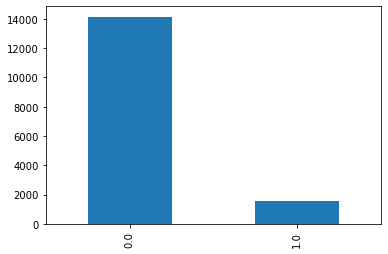

In [99]:
df_de.HOSPITAL_EXPIRE_FLAG.value_counts().plot(kind="bar")
#less than 2000 people are expired in the hospital in our dataset

0.0         AxesSubplot(0.1,0.15;0.363636x0.75)
1.0    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

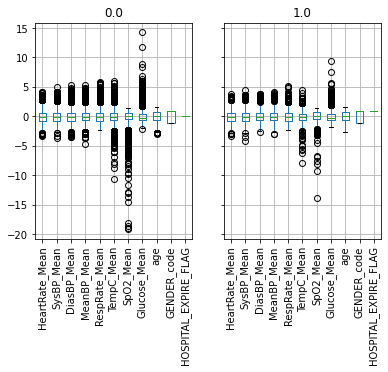

In [100]:
df_de.groupby("HOSPITAL_EXPIRE_FLAG").boxplot(rot=90)

# we observe that the diagnostic values of those who lived are more varied
# this is as expected since more than 90% of the observations lived (more observations, more varied)

In [101]:
df_de["LOS"] = response["LOS"]

<ipython-input-101-e0b983e1dad5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_de["LOS"] = response["LOS"]


In [102]:
df_de[["LOS"]].describe()

#the mean length of stay in the hospital is 3 days
# the longest one is almost 102 days

,LOS
count,15721.00000
mean,3.67602
std,5.13433
min,0.11200
25%,1.17820
50%,2.01770
75%,3.87520
max,101.73900


<AxesSubplot:ylabel='Frequency'>

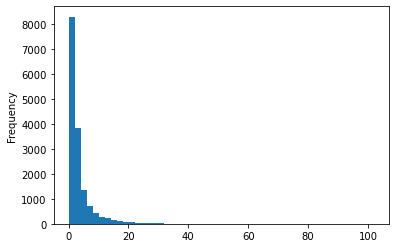

In [103]:
import math

w = 2
n = math.ceil((df_de.LOS.max() - df_de.LOS.min())/w)

df_de.LOS.plot(kind='hist', bins=n)

# the length of stay is postively skewed, only very few stayed in the hospital for more than 20 days

# Baseline

## Baseline Linear Model

We test the predicting power of the full/base dataset (without SVD/PCA and clustering).

For linear predictions, we will use the 'LOS' or length of stay as the dependent variable.

In [104]:
#importing train test split
from sklearn.model_selection import train_test_split

# storing features and labels
X = final_small_df
y_los = response['LOS']

#splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_los, test_size=0.33, random_state=42)

#importing the model we will use
from sklearn.ensemble import RandomForestRegressor

# fit the model
model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error

# make predictions
yhat = model.predict(X_test)
# evaluate predictions
mse = mean_squared_error(y_test, yhat)
print('MSE: %.3f' % mse)

MSE: 26.646


## Baseline Classifier Model

For classification, we will use the 'HOSPITAL_EXPIRE_FLAG' (whether the patient survived (0) or not(1)).

In [105]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# storing features and labels
X = final_small_df
y_flag = response['HOSPITAL_EXPIRE_FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y_flag, test_size=0.33, random_state=42)

# fit the model
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
# make predictions
yhat = model.predict(X_test)
# evaluate predictions
acc = accuracy_score(y_test, yhat)
print(acc)

0.910237659963437


[[9912   61]
 [ 972  158]]


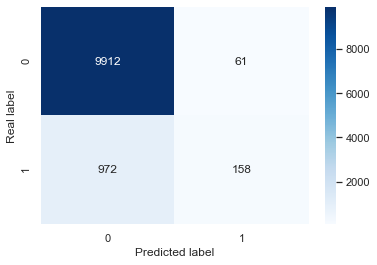

In [106]:
#class predictions
y_hat_cv = cvp(model, X_train, y_train, cv=10)

#confusion matrix - cross validated
cm =  confusion_matrix(y_pred=y_hat_cv, y_true=y_train, labels=[0,1])
print (cm)
# Plotting confusion matrix 
plot_confusion_matrix(cm, [0,1])

In [107]:
####  Classification report
print (classification_report(y_train, y_hat_cv))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      9973
           1       0.72      0.14      0.23      1130

    accuracy                           0.91     11103
   macro avg       0.82      0.57      0.59     11103
weighted avg       0.89      0.91      0.88     11103



Since the dataset is unbalanced, it is more difficult for the model to predict which patients survived or not.
However, we will not be using balancing methods as that is not our main concern. Our main concern is clustering and how it will help improve predictions after we add it as a column predictor.

## K-means on base data

We first do clustering on non-compressed data (without using SVD/PCA).

### Clustering and Classification

We will explore more ways that help us determine optimal number of k later on.

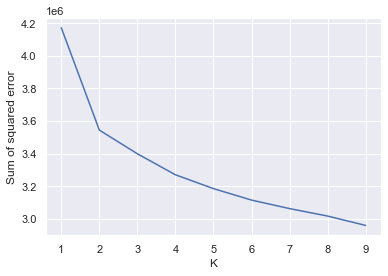

In [108]:
#finding k
#elbow
from sklearn.cluster import KMeans

sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(final_small_df)
    sse.append(km.inertia_)

plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)

#the elbow is clear at k=2

In [109]:
# k=2

#fitting the model
SEED=2305
km = KMeans(n_clusters=2, random_state=SEED)

y_predicted = km.fit_predict(final_small_df)
y_predicted

array([1, 1, 1, ..., 1, 1, 1])

In [110]:
y_predicted = pd.DataFrame(y_predicted)

1    16563
0       10
dtype: int64

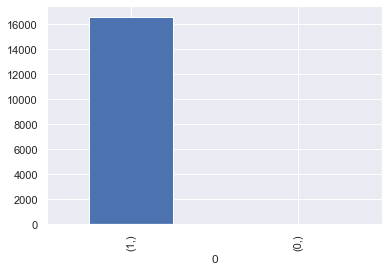

In [111]:
y_predicted.value_counts().plot(kind="bar")
#Almost all observations are clustered into one cluster (cluster 0)

y_predicted.value_counts()

Let's check how resulting clusters from doing k-means on the non-reduced data looks like.

Note that the resulting graph will not be pretty since we are just plotting the clusters agains two arbitrarily selected variables (based on correlation).

In [112]:
final_small_df_clus = pd.concat([final_small_df,y_predicted], axis=1)

In [113]:
final_small_df_clus.head()

,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean,age,GENDER_code,...,B_code_860,B_code_1020,B_code_other,C_code_523,C_code_753,C_code_805,C_code_972,C_code_1001,C_code_other,0
0,2.324601,-0.762061,-0.155632,-0.301951,0.885147,-1.190604,-0.534277,0.487975,0.441955,-1.144476,...,-0.171216,-0.133922,-1.506694,-0.157266,-0.138064,-0.178005,-0.195482,-0.146453,0.420487,1
1,-0.413930,-0.753238,0.170069,-0.278739,-0.748350,-0.513415,1.002829,-0.812498,-1.276278,-1.144476,...,-0.171216,-0.133922,0.663705,-0.157266,-0.138064,-0.178005,-0.195482,-0.146453,0.420487,1
2,0.407254,-0.388427,-0.553902,-0.451670,-0.789603,-0.177486,1.438618,1.767757,0.319224,-1.144476,...,-0.171216,-0.133922,0.663705,-0.157266,-0.138064,-0.178005,-0.195482,-0.146453,0.420487,1
3,0.875423,-0.738793,-1.922487,-1.366055,2.034127,1.838085,-0.836826,-0.317318,0.748782,-1.144476,...,-0.171216,-0.133922,0.663705,-0.157266,-0.138064,-0.178005,-0.195482,-0.146453,0.420487,1
4,0.816250,0.553615,1.089423,0.808966,-0.839650,-0.307744,0.919125,-0.780986,-0.846720,0.873762,...,-0.171216,-0.133922,0.663705,6.358656,-0.138064,-0.178005,-0.195482,-0.146453,-2.378197,1


In [114]:
final_small_df_columns = final_small_df.columns
final_small_df_clus_columns = final_small_df_columns
print(final_small_df_clus_columns)

Index(['HeartRate_Mean', 'SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean',
       'RespRate_Mean', 'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean', 'age',
       'GENDER_code',
       ...
       'B_code_855', 'B_code_860', 'B_code_1020', 'B_code_other', 'C_code_523',
       'C_code_753', 'C_code_805', 'C_code_972', 'C_code_1001',
       'C_code_other'],
      dtype='object', length=167)


In [115]:
final_small_df_clus_columns= final_small_df_clus_columns.insert(168, "cluster")
print(final_small_df_clus_columns)

Index(['HeartRate_Mean', 'SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean',
       'RespRate_Mean', 'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean', 'age',
       'GENDER_code',
       ...
       'B_code_860', 'B_code_1020', 'B_code_other', 'C_code_523', 'C_code_753',
       'C_code_805', 'C_code_972', 'C_code_1001', 'C_code_other', 'cluster'],
      dtype='object', length=168)


In [116]:
final_small_df_clus.columns = final_small_df_clus_columns
final_small_df_clus.head()

,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean,age,GENDER_code,...,B_code_860,B_code_1020,B_code_other,C_code_523,C_code_753,C_code_805,C_code_972,C_code_1001,C_code_other,cluster
0,2.324601,-0.762061,-0.155632,-0.301951,0.885147,-1.190604,-0.534277,0.487975,0.441955,-1.144476,...,-0.171216,-0.133922,-1.506694,-0.157266,-0.138064,-0.178005,-0.195482,-0.146453,0.420487,1
1,-0.413930,-0.753238,0.170069,-0.278739,-0.748350,-0.513415,1.002829,-0.812498,-1.276278,-1.144476,...,-0.171216,-0.133922,0.663705,-0.157266,-0.138064,-0.178005,-0.195482,-0.146453,0.420487,1
2,0.407254,-0.388427,-0.553902,-0.451670,-0.789603,-0.177486,1.438618,1.767757,0.319224,-1.144476,...,-0.171216,-0.133922,0.663705,-0.157266,-0.138064,-0.178005,-0.195482,-0.146453,0.420487,1
3,0.875423,-0.738793,-1.922487,-1.366055,2.034127,1.838085,-0.836826,-0.317318,0.748782,-1.144476,...,-0.171216,-0.133922,0.663705,-0.157266,-0.138064,-0.178005,-0.195482,-0.146453,0.420487,1
4,0.816250,0.553615,1.089423,0.808966,-0.839650,-0.307744,0.919125,-0.780986,-0.846720,0.873762,...,-0.171216,-0.133922,0.663705,6.358656,-0.138064,-0.178005,-0.195482,-0.146453,-2.378197,1


In [117]:
print(final_small_df_clus['cluster'].corr(final_small_df_clus['age']))
print(final_small_df_clus['cluster'].corr(final_small_df_clus['RespRate_Mean']))
print(final_small_df_clus['cluster'].corr(final_small_df_clus['HeartRate_Mean']))

-0.014176710270429053
-0.02748827427264322
-0.02497532529284251


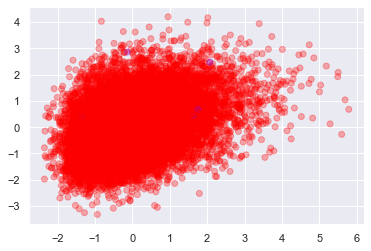

In [118]:
# we graph based on arbitrarily chosen columns and the clustering was based on 168 columns
# hence we do not expect the graph to be pretty
plt.scatter(final_small_df_clus['RespRate_Mean'], final_small_df_clus["HeartRate_Mean"], c=y_predicted, cmap='rainbow', alpha = 0.3)

Now, let's check whether it al least improved our predictions by training and testing based on the data with added clusters.

In [119]:
X = final_small_df_clus
y_flag = response['HOSPITAL_EXPIRE_FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y_flag, test_size=0.33, random_state=42)

# fit the model
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
# make predictions
yhat = model.predict(X_test)
# evaluate predictions
acc = accuracy_score(y_test, yhat)
print(acc)

0.9118829981718465


Note that accuracy increased a bit from 0.910 to 0.912.

[[9914   59]
 [ 982  148]]


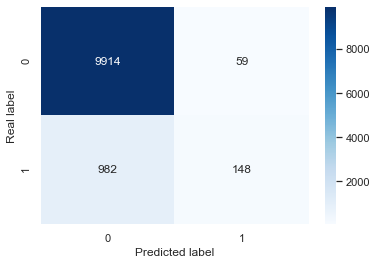

In [120]:
#class predictions
y_hat_cv = cvp(model, X_train, y_train, cv=10)

#confusion matrix - cross validated
cm =  confusion_matrix(y_pred=y_hat_cv, y_true=y_train, labels=[0,1])
print (cm)
# Plotting confusion matrix 
plot_confusion_matrix(cm, [0,1])

In [121]:
####  Classification report
print (classification_report(y_train, y_hat_cv))

# the f-1 score for predicting whether the patient died or not increased from 0.23 to 0.24

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      9973
           1       0.71      0.13      0.22      1130

    accuracy                           0.91     11103
   macro avg       0.81      0.56      0.59     11103
weighted avg       0.89      0.91      0.88     11103



# SVD

Now we will perform Singular Value Decomposition (SVD). This is to reduce the dimensionality of our data.

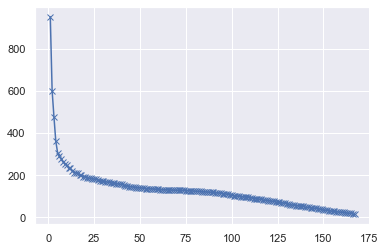

In [122]:
# SVD
Ul, Dl, Vt = np.linalg.svd(final_small_df)
Vl = Vt.transpose()
# print the new coordinate vectors:
#plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.plot(range(1, final_small_df.shape[1]+1), Dl, 'bx-')

In [123]:
Dl[0:10]
#we retain only the first five components since the rate of decrease declined from the 6th to 7th component

array([951.13085295, 600.06308098, 475.90270612, 360.94228647,
       306.02358043, 290.3428804 , 278.74242795, 264.14420728,
       251.36102351, 247.5088128 ])

In [124]:
r = 5
Z = np.matmul(Ul[:, 0:r], np.diag(Dl[0:r]))

In [125]:
Z

array([[-1.36800536,  2.07846248, -1.41868046, -3.37045519,  0.72582516],
       [-1.05378491,  0.79466401, -0.22303983, -0.72551715,  0.15590137],
       [-1.8977802 ,  1.70833413, -2.31390662,  0.6342082 ,  1.20410163],
       ...,
       [-0.6589256 ,  3.25815471, -3.70936111,  1.46788856,  2.39548897],
       [-1.0785627 ,  0.76679213, -0.85556791,  0.4475362 ,  0.82219296],
       [-1.69530314,  1.33143832, -0.2422836 , -0.56378273,  0.07743046]])

In [126]:
Z.shape

(16573, 5)

In [127]:
final_small_df.shape

(16573, 167)

Our Z matrix explains a significant part in the variation of our data. It only has 5 columns so it will be easier to work on this relative to the one with 168 columns before.

In [128]:
Z = np.matmul(final_small_df, Vt.transpose()[:, 0:r])

In [129]:
Z.head()

,0,1,2,3,4
0,-1.368005,2.078462,-1.418680,-3.370455,0.725825
1,-1.053785,0.794664,-0.223040,-0.725517,0.155901
2,-1.897780,1.708334,-2.313907,0.634208,1.204102
3,-2.212128,5.245405,1.369185,-5.911640,0.904614
4,-1.287072,2.586002,1.135236,0.918652,0.212668


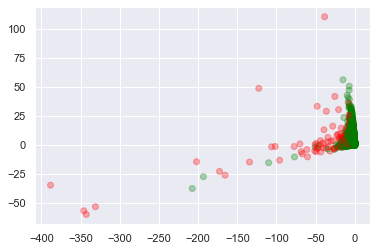

In [130]:
colors = {0:'green', 1:'red'}
plt.scatter(Z[0], Z[1], c=response['HOSPITAL_EXPIRE_FLAG'].map(colors), alpha=0.3)

We observe that those with Z[0] values (x-axis) nearer to 0 are more likely to live than those who have negative values on the same component. Those who lived are more likely to have positive Z[1] values (y-axis).

## Linear Model (Z)

In [131]:
X = Z
y_los = response['LOS']

X_train, X_test, y_train, y_test = train_test_split(X, y_los, test_size=0.33, random_state=42)

# fit the model
model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)

# make predictions
yhat = model.predict(X_test)
# evaluate predictions
mse = mean_squared_error(y_test, yhat)
print('MSE: %.3f' % mse)

MSE: 29.172


The MSE increased from 26.646 to 29.172. This is expected since we have reduced the dimensinality of the data so the MSE will increase a bit. But whether this increase is large or not is difficult to say. I am inclined to say that it is not since from 168 columns, we are using the 5 columns. The MSE we got from Z is still not that far from the one with full dimensions.

## Classifier Model (Z)

In [132]:
X = Z
y_flag = response['HOSPITAL_EXPIRE_FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y_flag, test_size=0.33, random_state=42)

# fit the model
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
# make predictions
yhat = model.predict(X_test)
# evaluate predictions
acc = accuracy_score(y_test, yhat)
print(acc)

0.9058500914076782


The accruacy from using the reduced form of the data decreased marginally from 0.910 to 0.905. But that is okay since we are trading some accuracy for significantly faster fitting/training.

## Linear Model (Z + clusters)

In [133]:
#creating a new data frame containing both the Z matrix and clusters

cluster = final_small_df_clus["cluster"]

Z_clus = Z.copy()
Z_clus["cluster"] = cluster

In [134]:
Z.head()

,0,1,2,3,4
0,-1.368005,2.078462,-1.418680,-3.370455,0.725825
1,-1.053785,0.794664,-0.223040,-0.725517,0.155901
2,-1.897780,1.708334,-2.313907,0.634208,1.204102
3,-2.212128,5.245405,1.369185,-5.911640,0.904614
4,-1.287072,2.586002,1.135236,0.918652,0.212668


In [135]:
Z_clus.head()

,0,1,2,3,4,cluster
0,-1.368005,2.078462,-1.418680,-3.370455,0.725825,1
1,-1.053785,0.794664,-0.223040,-0.725517,0.155901,1
2,-1.897780,1.708334,-2.313907,0.634208,1.204102,1
3,-2.212128,5.245405,1.369185,-5.911640,0.904614,1
4,-1.287072,2.586002,1.135236,0.918652,0.212668,1


In [136]:
X = Z_clus
y_los = response['LOS']

X_train, X_test, y_train, y_test = train_test_split(X, y_los, test_size=0.33, random_state=42)

# fit the model
model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)

# make predictions
yhat = model.predict(X_test)
# evaluate predictions
mse = mean_squared_error(y_test, yhat)
print('MSE: %.3f' % mse)

MSE: 29.214


The MSE increased a bit from 29.172 to 29.214.

## Classifier Model (Z + cluster)

In [137]:
X = Z_clus
y_flag = response['HOSPITAL_EXPIRE_FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y_flag, test_size=0.33, random_state=42)

# fit the model
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
# make predictions
yhat = model.predict(X_test)
# evaluate predictions
acc = accuracy_score(y_test, yhat)
print(acc)

0.9054844606946983


Adding the clusters to the te Z matrix did not improve accuracy, it stayed at around 0.905.

# PCA

Now we do Principal Component Analysis (PCA). From how I understood it, PCA is very similar to SVD. But it is easier to implement in Python. Further, while in SVD, we could choose how many columns we would like to retain for our Z matrix, in PCA (while we could do that as well, I think), it is more usual to just retain the first principal component and the second principal component.

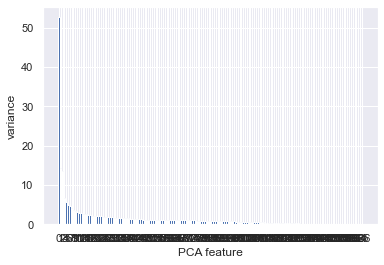

In [138]:
from sklearn.decomposition import PCA

from sklearn.pipeline import make_pipeline

# Create a PCA instance: pca
pca = PCA()

# Fit the pipeline to 'samples'
pca.fit(final_small_df)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

Most of the variations are explained by the first component. But I will keep the second one as well.

In [139]:
pca = PCA(n_components=2)
pca.fit(final_small_df)

transformed = pca.transform(final_small_df)
print(transformed.shape)

(16573, 2)


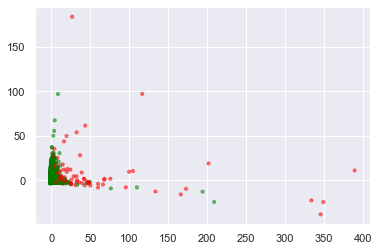

In [140]:
# hospital flag and the main dataset in 2 dimensions (using PCA)

xs = transformed[:,0]
ys = transformed[:,1]

colors = {0:'green', 1:'red'}
plt.scatter(xs, ys, c=response['HOSPITAL_EXPIRE_FLAG'].map(colors), alpha=0.5, s=10)
plt.show()

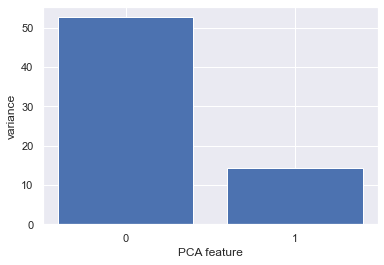

In [141]:
pca.fit(final_small_df)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

The first component for the PCA explains more than half in the variance of the data while the second one is explained by the second component.

Note: When a dataframe name contains "Z", it's from SVD. If it contains 'PC' or 'transformed', its from PCA. I use both since for some clustering methods, it may take too long to cluster based on >2 columns, while some son't want too few columns (from my experience, Affinity Propagation).

# Clustering

# K-means

First, we do K-means (a.k.a. Lloyd’s algorithm). KMeans clusters data by "trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares".
Source: https://scikit-learn.org/stable/modules/clustering.html#k-means

From how I understood it, it minimized specifies clusters by moving the centroids until it has minimized the distances between points.

## Elbow

While we already did K-means with elbow as method for determining the number of clusters, we revisit it in this section so we could easily compare our outputs from other methods do determine number of clusters such as Silhouette method and Optimal Gap.

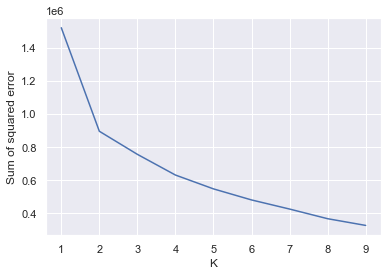

In [142]:
#finding k
#elbow
from sklearn.cluster import KMeans

sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(Z)
    sse.append(km.inertia_)

plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)

In [143]:
# k=2

#fitting the model
SEED=2305
km = KMeans(n_clusters=2)
y_predicted = km.fit_predict(Z)
y_predicted

array([0, 0, 0, ..., 0, 0, 0])

In [144]:
type(y_predicted)
y_predicted = pd.DataFrame(y_predicted)

In [145]:
type(Z)
Z = pd.DataFrame(Z)

In [146]:
Z_df = pd.concat([Z, y_predicted], axis=1)

In [147]:
Z_df.columns = [0,1,2,3,4,'cluster']

In [148]:
Z_df.head()

,0,1,2,3,4,cluster
0,-1.368005,2.078462,-1.418680,-3.370455,0.725825,0
1,-1.053785,0.794664,-0.223040,-0.725517,0.155901,0
2,-1.897780,1.708334,-2.313907,0.634208,1.204102,0
3,-2.212128,5.245405,1.369185,-5.911640,0.904614,0
4,-1.287072,2.586002,1.135236,0.918652,0.212668,0


In [149]:
Z_df.shape

(16573, 6)

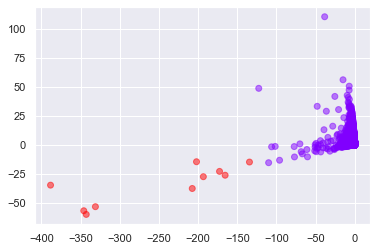

In [150]:
plt.scatter(Z[0], Z[1], c=Z_df['cluster'],cmap='rainbow', alpha=0.5)

We observe than using the Z matrix, those with x and y values farther from the origin are more likely to be included in the Cluster 1 (red).

We will also check later if our results would differ if we used the reduced dimension from PCA instead. Just to be sure, 'cause we expect them to be very similar, if not almost the same.

### [k = 2] Linear Model (SVD+ K-means (elbow)) 

In [151]:
X = Z_df
y_los = response['LOS']

X_train, X_test, y_train, y_test = train_test_split(X, y_los, test_size=0.33, random_state=42)

from sklearn.ensemble import RandomForestRegressor

# fit the model
model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error

# make predictions
yhat = model.predict(X_test)
# evaluate predictions
mse = mean_squared_error(y_test, yhat)
print('MSE: %.3f' % mse)

MSE: 29.214


### [k = 2] Classifier Model (SVD + K-means (elbow))

In [152]:
X = Z_df
y_flag = response['HOSPITAL_EXPIRE_FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y_flag, test_size=0.33, random_state=42)

# fit the model
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
# make predictions
yhat = model.predict(X_test)
# evaluate predictions
acc = accuracy_score(y_test, yhat)
print(acc)

0.9056672760511884


Now we will check if our results would look different if we used the ones from PCA instead as input data.

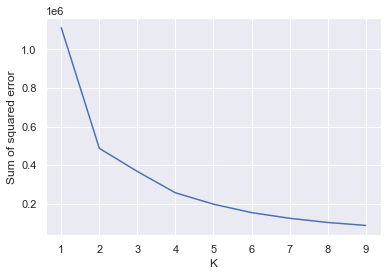

In [153]:
#finding k
#elbow
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(transformed)
    sse.append(km.inertia_)

plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)

# elbow also showed k=2

In [154]:
# k=2

#fitting the model
SEED=2305
km = KMeans(n_clusters=2)
y_predicted = km.fit_predict(transformed)
y_predicted

array([0, 0, 0, ..., 0, 0, 0])

In [155]:
type(y_predicted)
y_predicted = pd.DataFrame(y_predicted)

In [156]:
transformed.shape

(16573, 2)

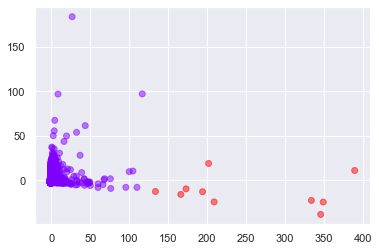

In [157]:
plt.scatter(transformed[:,0], transformed[:,1], c=y_predicted, cmap='rainbow', alpha=0.5)

The results from using SVD and PCA are really similar, it looks like the points are just flipped on the axis. 

### [k = 2] Linear Model (PCA+ K-means (elbow)) 

Now we check whether our predictions have improved relative to our baseline (no clusters)

In [158]:
print(type(y_predicted))
y_predicted = pd.DataFrame(y_predicted)

<class 'pandas.core.frame.DataFrame'>


In [159]:
print(type(transformed))
transformed = pd.DataFrame(transformed)

<class 'numpy.ndarray'>


In [160]:
transformed_df = pd.concat([transformed, y_predicted], axis=1)

In [161]:
transformed_df.columns = [0,1,'cluster']

In [162]:
transformed_df.head()

,0,1,cluster
0,-0.167359,-0.782956,0
1,-0.320852,-1.952058,0
2,0.472167,0.186024,0
3,0.260693,0.408858,0
4,-0.211070,0.021515,0


In [163]:
transformed_df.shape

(16573, 3)

In [164]:
X = transformed_df
y_los = response['LOS']

X_train, X_test, y_train, y_test = train_test_split(X, y_los, test_size=0.33, random_state=42)

# fit the model
model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error

# make predictions
yhat = model.predict(X_test)
# evaluate predictions
mse = mean_squared_error(y_test, yhat)
print('MSE: %.3f' % mse)

MSE: 32.296


The MSE from using the PCA with clusters is a bit higher from using the Z with clusters (32.278 vs. 29.214)

### [k = 2] Classifier Model (PCA + K-means (elbow))

In [165]:
X = transformed_df
y_flag = response['HOSPITAL_EXPIRE_FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y_flag, test_size=0.33, random_state=42)

# fit the model
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
# make predictions
yhat = model.predict(X_test)
# evaluate predictions
acc = accuracy_score(y_test, yhat)
print(acc)

0.9005484460694698


The accuracy from using the PCA+clusters were marginally lower compared to the one from SVD+clusters (0.8998 vs 0.9057)

## Silhouette

Now, we try another way to determine number of clusters to supply the k-means algorithm.

The silhouette score measures of how similar an object is to its own cluster compared to other clusters.

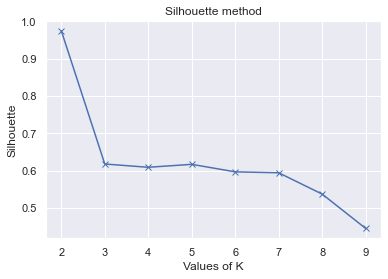

Max average silhouette score is : 0.97465  for n_clusters = 2


In [166]:
K = range(2,10) 
SEED = 135

from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_by_k=[]

for n_clusters in K:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=SEED)
    cluster_labels = clusterer.fit_predict(Z)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(Z, cluster_labels)
    
    silhouette_by_k.append(silhouette_avg)

plt.plot(K, silhouette_by_k, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Silhouette') 
plt.title('Silhouette method') 
plt.show() 
    
print("Max average silhouette score is :", round(max(silhouette_by_k),5), 
      " for n_clusters =", K[silhouette_by_k.index(max(silhouette_by_k))])

From k=3 decrease in inertia (WCSS) becomes linear, so we select k=3.

Another way to visualize sillohouette score is as follows.

In [167]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
def silhouette_plot(X, y, n_clusters, ax=None):
	if ax is None:
		ax = plt.gca()
		# Compute the silhouette scores for each sample
		silhouette_avg = silhouette_score(X, y)
		sample_silhouette_values = silhouette_samples(X, y)
		y_lower = padding = 2
		for i in range(n_clusters):
	# Aggregate the silhouette scores for samples belonging to
			ith_cluster_silhouette_values = sample_silhouette_values[y == i]
			ith_cluster_silhouette_values.sort()
			size_cluster_i = ith_cluster_silhouette_values.shape[0]
			y_upper = y_lower + size_cluster_i
			color = cm.nipy_spectral(float(i) / n_clusters)
			ax.fill_betweenx(np.arange(y_lower, y_upper),
							0,ith_cluster_silhouette_values,
							facecolor=color,
							edgecolor=color,
							alpha=0.7)
			# Label the silhouette plots with their cluster numbers at the middle
			ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i + 1))
			# Compute the new y_lower for next plot
			y_lower = y_upper + padding
		ax.set_xlabel("The silhouette coefficient values")
		ax.set_ylabel("Cluster label")
		# The vertical line for average silhoutte score of all the values
		ax.axvline(x=silhouette_avg, c='r', alpha=0.8, lw=0.8, ls='-')
		ax.annotate('Average',
					xytext=(silhouette_avg, y_lower * 1.025),
					xy=(0, 0),
					ha='center',
					alpha=0.8,
					c='r')
		ax.set_yticks([]) # Clear the yaxis labels / ticks
		ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
		ax.set_ylim(0, y_upper + 1)
		ax.set_xlim(-0.075, 1.0)
		return ax

<AxesSubplot:xlabel='The silhouette coefficient values', ylabel='Cluster label'>

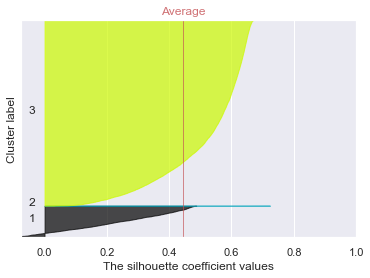

In [168]:
### Silhoutte Plot
silhouette_plot(Z,cluster_labels,3,ax=None)

The thickness of each silhouette below shows how much data points belong to a particular class. We observe that most observations belong to cluster 3. Further, each cluster passes the average sillohoutte score, so our clustering is good, even though the size of clusters are very uneven.

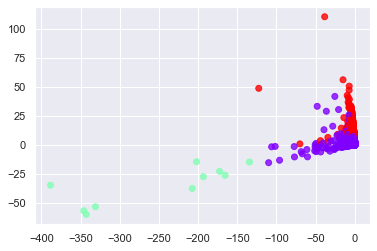

In [169]:
# Results of selecting k=3
kmeanModel = KMeans(n_clusters=3, random_state=SEED).fit(Z) 
kmeanModel.fit(Z)
predicted=kmeanModel.predict(Z)

# Plot dataset with clusters
plt.scatter(Z[0],Z[1],c=predicted,cmap='rainbow', alpha=0.8)

We observe above that data points far from the origin are identfied as one cluster (green), those near to origin but with negative y-values as another cluster (purple), and those near the origin but have positive y-values (red) as another.

Now, we check whether the perfomance of model from using k=3 (from silohouette) will improve relative to that of k=2 (from elbow).

In [170]:
cluster_labels = pd.DataFrame(predicted)
Z_si = pd.concat([Z, cluster_labels], axis=1)
Z_si.columns = [0,1,2,3,4,"clusters"]

In [171]:
#we have to introduce clusters as dummies if k>2

Z_si = pd.get_dummies(Z_si, columns=['clusters'],drop_first=True)

In [172]:
Z_si.describe()

,0,1,2,3,4,clusters_1,clusters_2
count,16573.000000,16573.000000,16573.000000,16573.000000,16573.000000,16573.000000,16573.000000
mean,-1.587946,2.891894,0.125088,-0.867991,-0.055319,0.000603,0.066313
std,7.215770,3.655735,3.694723,2.666076,2.376566,0.024557,0.248835
min,-388.400571,-60.242234,-204.726545,-35.547470,-85.759040,0.000000,0.000000
25%,-1.595153,1.036890,-0.346776,-1.597579,-1.015818,0.000000,0.000000
50%,-0.898196,1.937691,0.133069,-0.678622,-0.094476,0.000000,0.000000
75%,-0.481138,3.553117,0.801850,0.039647,0.689688,0.000000,0.000000
max,0.096273,110.418038,33.455192,39.325991,29.886452,1.000000,1.000000


### [k=3] Linear Model (SVD+ K-means (silhouette))

In [173]:
X = Z_si
y_los = response['LOS']

X_train, X_test, y_train, y_test = train_test_split(X, y_los, test_size=0.33, random_state=42)

# fit the model
model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error

# make predictions
yhat = model.predict(X_test)
# evaluate predictions
mse = mean_squared_error(y_test, yhat)
print('MSE: %.3f' % mse)

MSE: 29.252


The MSE increased from 29.214 to 29.00 the MSE we got from using k=2. They're not that different.

### [k=3] Classifier Model (SVD + K-means (silhouette))

In [174]:
X = Z_si
y_flag = response['HOSPITAL_EXPIRE_FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y_flag, test_size=0.33, random_state=42)

# fit the model
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
# make predictions
yhat = model.predict(X_test)
# evaluate predictions
acc = accuracy_score(y_test, yhat)
print(acc)


0.9060329067641681


Performance of classification improved a bit from 0.9057 to 0.9060 (from k=2 and k=3, respectively).

## Optimal Gap

In [175]:
from gap_statistic import OptimalK

optimalK = OptimalK()

n_clusters = optimalK(Z, cluster_array=np.arange(2, 10))
print('Optimal clusters: ', n_clusters)

Optimal clusters:  9


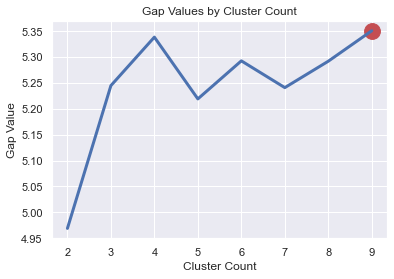

In [176]:
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

In [177]:
print(n_clusters)

9


Since from optimal gap, the number of clusters is also k=3, we don't have to repeat the k-means for k=3.

## Minibatch K-Means

Although computing using K-means didn't take very long, let's also try using Minibatch K-means. Minibatch K-means "uses mini-batches to reduce the computation time, while still attempting to optimise the same objective function." Source: https://scikit-learn.org/stable/modules/clustering.html#k-means

In [178]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=3,
                          random_state=0,
                          batch_size=2072,
                          max_iter=10).fit(Z)

labels = kmeans.predict(Z)

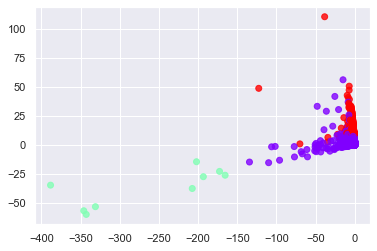

In [179]:
# Plot dataset with clusters
plt.scatter(Z[0],Z[1],c=labels,cmap='rainbow', alpha=0.8)

The results from the minibatch k-means were very similar to the k-means implemented on the full dataset.

# Agglomerative Clustering 

In Agglomerative Clustering, we are comparing pairwise distances between observations. From how I understood it, it merges observations based on degree of similarity. To be exact, the agglomerative clustering object "performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together." Source: https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering

In contrast to K-means, we do not have to define the number of clusters in the beginning but instead we identify it after observing the dendrogram.

For heirarchical/agglomerative clustering, I will use the 2-column dataset with 2000 samples we got from PCA so it will be faster.

In [180]:
transformed_flag = transformed.copy() #creating deap copy to avoid alteration of original pca matrix
transformed_flag["HOSPITAL_EXPIRE_FLAG"] = response["HOSPITAL_EXPIRE_FLAG"]
transformed_flag = transformed.sample(2000, random_state=123)

In [181]:
#merging the pca matrix and the response df
transformed_flag = pd.merge(transformed, response, left_index=True, right_index=True)

In [182]:
transformed_flag.shape

(15721, 9)

In [183]:
transformed_flag.head()

,0,1,Unnamed: 0,subject_id,hadm_id,icustay_id,HOSPITAL_EXPIRE_FLAG,LOS,age
0,-0.167359,-0.782956,0,55440,195768,228357,0,4.5761,70
1,-0.320852,-1.952058,1,76908,126136,221004,0,0.7582,42
2,0.472167,0.186024,2,95798,136645,296315,0,3.7626,68
3,0.260693,0.408858,3,40708,102505,245557,0,3.8734,75
4,-0.211070,0.021515,5,63311,180102,287519,0,1.8490,49


In [184]:
#retaining only the pca matrix and the hospital expired flag
transformed_flag = transformed_flag.drop(['Unnamed: 0', 'subject_id', 'hadm_id', 'icustay_id', 'age', 'LOS'], axis=1)

In [185]:
transformed_flag.head()

,0,1,HOSPITAL_EXPIRE_FLAG
0,-0.167359,-0.782956,0
1,-0.320852,-1.952058,0
2,0.472167,0.186024,0
3,0.260693,0.408858,0
4,-0.211070,0.021515,0


In [186]:
transformed_flag.shape

(15721, 3)

In [187]:
# getting 2000 samples
transformed_flag = transformed_flag.sample(2000, random_state=123)

In [188]:
transformed_flag_no_flag = transformed_flag.drop(['HOSPITAL_EXPIRE_FLAG'], axis=1)

In [189]:
import scipy.cluster.hierarchy as sch

#Lets create a dendrogram 
# variable linkage is actually the algorithm  itself of hierarchical clustering
links=sch.linkage(transformed_flag_no_flag, method  = "ward")
# Ward method is a method that tries to minimize the variance within each cluster

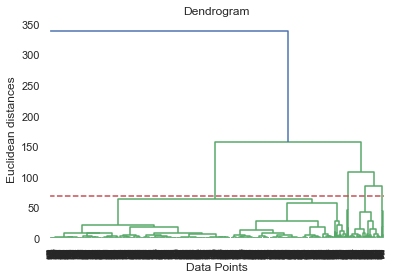

In [190]:
datasetdendrogram = sch.dendrogram(links)
plt.title('Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Euclidean distances')
plt.axhline(y=70, color='r', linestyle='--') #cutoff point after observing the dendrogram
plt.show()

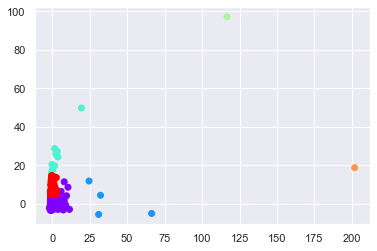

In [191]:
from sklearn.cluster import AgglomerativeClustering 

hc = AgglomerativeClustering( affinity = 'euclidean', linkage ='ward', distance_threshold=70, n_clusters=None)

predicted=hc.fit_predict(transformed_flag_no_flag)

# Plot dataset with clusters
plt.scatter(transformed_flag_no_flag[0],transformed_flag_no_flag[1],c=predicted, cmap='rainbow')

In [192]:
len(pd.Series(predicted).unique())

6

As with the previous plots, the points farther from the origin are identified as one cluster, and points nearer the origin are indentified as another.

## Random Forest

### Baseline

In [193]:
X = transformed_flag_no_flag
y_flag =  transformed_flag['HOSPITAL_EXPIRE_FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y_flag, test_size=0.33, random_state=42)

# fit the model
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
# make predictions
yhat = model.predict(X_test)
# evaluate predictions
acc = accuracy_score(y_test, yhat)
print(acc)

0.9


In [194]:
cluster_labels = pd.DataFrame(predicted)
cluster_labels.shape

(2000, 1)

In [195]:
cluster_labels.head()

,0
0,0
1,0
2,0
3,0
4,0


In [196]:
transformed_flag_index = transformed_flag.index

In [197]:
cluster_labels.index = transformed_flag_index

### With clusters

In [198]:
transformed_sample_df = pd.concat([transformed_flag_no_flag, cluster_labels], axis=1,ignore_index=True)
transformed_sample_df.columns = [0,1,"clusters"]

In [199]:
transformed_sample_df.head()

,0,1,clusters
5800,-1.000127,-1.641363,0
4830,-0.015585,2.004892,0
7654,-1.061591,-1.203699,0
4052,-0.515905,0.905614,0
4746,0.326006,1.068219,0


In [200]:
transformed_sample_df.shape

(2000, 3)

In [201]:
#let's introduce the clusters as dummies

transformed_sample_df_dum = pd.get_dummies(transformed_sample_df, columns=['clusters'],drop_first=True)

In [202]:
X = transformed_sample_df_dum
y_flag = transformed_flag['HOSPITAL_EXPIRE_FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y_flag, test_size=0.33, random_state=42)

# fit the model
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
# make predictions
yhat = model.predict(X_test)
# evaluate predictions
acc = accuracy_score(y_test, yhat)
print(acc)

0.8984848484848484


Accuracy did not improve from without clusters to with clusters.

## Logistic Regression

Let's try using a different model, logitstic regression instead of random forest.

### Baseline

In [203]:
X = transformed_flag_no_flag
y_flag =  transformed_flag['HOSPITAL_EXPIRE_FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y_flag, test_size=0.33, random_state=42)

# fit the model
model = LogisticRegression(random_state=1)
model.fit(X_train, y_train)
# make predictions
yhat = model.predict(X_test)
# evaluate predictions
acc = accuracy_score(y_test, yhat)
print(acc)

0.9106060606060606


### With clusters

In [204]:
X = transformed_sample_df_dum
y_flag = transformed_flag['HOSPITAL_EXPIRE_FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y_flag, test_size=0.33, random_state=42)

# fit the model
model = LogisticRegression(random_state=1)
model.fit(X_train, y_train)
# make predictions
yhat = model.predict(X_test)
# evaluate predictions
acc = accuracy_score(y_test, yhat)
print(acc)

0.9106060606060606


Accuracy stayed the same for logistic regression.

# Affinity Propagation

Affinity clustering is another heirarchical clustering method wherein each node is initially a cluster  but in each round, it is merged to the cluster nearest to it, until the desired number of clusters is reached.

In [205]:
#Z_5000 = Z.append(response, ignore_index=False)
Z_5000 = pd.concat([Z, response["HOSPITAL_EXPIRE_FLAG"]], axis=1)

In [206]:
Z_5000 = Z_5000.sample(5000, random_state=988)
Z_5000.shape

(5000, 6)

In [207]:
Z_5000.head()

,0,1,2,3,4,HOSPITAL_EXPIRE_FLAG
5914,-0.509024,1.400578,-0.429175,-1.146044,0.595334,0.0
15300,-1.335669,9.059504,4.796508,2.372974,-1.071691,0.0
14619,-1.815785,1.786674,-1.019646,0.419561,1.792177,0.0
15138,-3.696765,26.618635,15.695990,7.166551,0.913325,0.0
13819,-0.694486,2.839786,0.334169,-0.612068,-1.576407,0.0


In [208]:
#changing column names
Z_5000.columns = ['A', 'B', 'C', 'D', 'E', 'HOSPITAL_EXPIRE_FLAG']

In [209]:
Z_5000.dtypes

A                       float64
B                       float64
C                       float64
D                       float64
E                       float64
HOSPITAL_EXPIRE_FLAG    float64
dtype: object

In [210]:
Z_5000.isnull().sum()

A                       231
B                       231
C                       231
D                       231
E                       231
HOSPITAL_EXPIRE_FLAG    247
dtype: int64

In [211]:
Z_5000 = Z_5000.dropna()

In [212]:
Z_5000.isnull().sum()

A                       0
B                       0
C                       0
D                       0
E                       0
HOSPITAL_EXPIRE_FLAG    0
dtype: int64

In [213]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(random_state=123)
clustering = af.fit(Z_5000[['A', 'B', 'C', 'D', 'E']])

In [214]:
np.unique(clustering.labels_)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

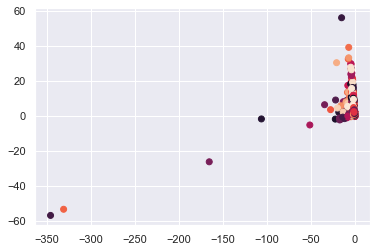

In [215]:
# Plot dataset with clusters
plt.scatter(Z_5000['A'],Z_5000['B'],c=clustering.labels_)

In [216]:
len(pd.Series(clustering.labels_).unique())

254

In [217]:
#storing clusters
cluster_labels = clustering.labels_

The number of clusters identified by affinity propagation is k=254.

### Baseline

In [218]:
#assigning featurs and labels
X = Z_5000[['A', 'B', 'C', 'D', 'E']]
y_flag =  Z_5000[['HOSPITAL_EXPIRE_FLAG']]

X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y_flag), test_size=0.33, random_state=42)

# fit the model
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
# make predictions
yhat = model.predict(X_test)
# evaluate predictions
acc = accuracy_score(y_test, yhat)
print(acc)

0.9002009377093101


In [219]:
cluster_labels.shape

(4522,)

In [220]:
Z_5000.shape

(4522, 6)

### With clusters

In [221]:
Z_5000.head()

,A,B,C,D,E,HOSPITAL_EXPIRE_FLAG
5914,-0.509024,1.400578,-0.429175,-1.146044,0.595334,0.0
15300,-1.335669,9.059504,4.796508,2.372974,-1.071691,0.0
14619,-1.815785,1.786674,-1.019646,0.419561,1.792177,0.0
15138,-3.696765,26.618635,15.695990,7.166551,0.913325,0.0
13819,-0.694486,2.839786,0.334169,-0.612068,-1.576407,0.0


In [222]:
pd.DataFrame(cluster_labels).head()

,0
0,218
1,9
2,86
3,247
4,30


In [223]:
Z_5000_index = Z_5000.index
cluster_labels = pd.DataFrame(cluster_labels)
cluster_labels.index = Z_5000_index

In [225]:
df3_merged = pd.merge(Z_5000, cluster_labels, left_index=True, right_index=True)

In [226]:
df3_merged.head()

,A,B,C,D,E,HOSPITAL_EXPIRE_FLAG,0
5914,-0.509024,1.400578,-0.429175,-1.146044,0.595334,0.0,218
15300,-1.335669,9.059504,4.796508,2.372974,-1.071691,0.0,9
14619,-1.815785,1.786674,-1.019646,0.419561,1.792177,0.0,86
15138,-3.696765,26.618635,15.695990,7.166551,0.913325,0.0,247
13819,-0.694486,2.839786,0.334169,-0.612068,-1.576407,0.0,30


In [227]:
df3_merged.columns = ['A', 'B', 'C', 'D', 'E', 'HOSPITAL_EXPIRE_FLAG', 'cluster']

In [228]:
# we introduce clusters as dummies
df3_merged = pd.get_dummies(df3_merged, columns=['cluster'],drop_first=True)

In [229]:
# we check the shape to see if the dummies were properly introduced
df3_merged.shape

(4522, 259)

In [230]:
#assigning featurs and labels

X = df3_merged.drop(['HOSPITAL_EXPIRE_FLAG'], axis=1)
y_flag =  Z_5000[['HOSPITAL_EXPIRE_FLAG']]

X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y_flag), test_size=0.33, random_state=42)

# fit the model
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
# make predictions
yhat = model.predict(X_test)
# evaluate predictions
acc = accuracy_score(y_test, yhat)
print(acc)

0.898191560616209


Accuracy dropped a bit when we included clustering from 0.900 to 0.898.

*I think that adding clusters does not help improve the accuracy of my models. So I won't be doing them in the next part. Instead, I will just explore the different clustering methods.*

# Mean-shift

Mean-shift clustering "aims to discover blobs in a smooth density of samples. It is a centroid based algorithm, which works by updating candidates for centroids to be the mean of the points within a given region." Source: https://scikit-learn.org/stable/modules/clustering.html#mean-shift

In this way, I think it's very similar to K-Means but we do not have to define k beforehand.

In [231]:
# Compute clustering with MeanShift
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

# The following bandwidth can be automatically detected using
#bandwidth = estimate_bandwidth(Z, quantile=0.2, n_samples=500)

#ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms = MeanShift(bin_seeding=True)
ms.fit(Z)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 146


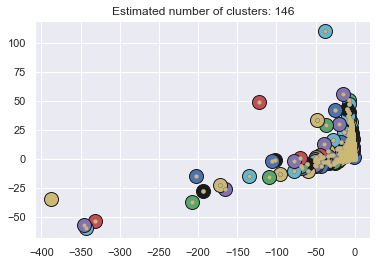

In [232]:
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(Z[0], Z[1], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

As expected, it did form blobs. But the blobs are not too obvious since there are a lot of them. 

# Spectral Clustering

I used a smaller dataset (Z with 2000 observation) so the computation time would be faster.

Currently, this method also requires the number of clusters to be specified in advance but by not specifying n_cluster, it tries to automatically infer the optimal number of k.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


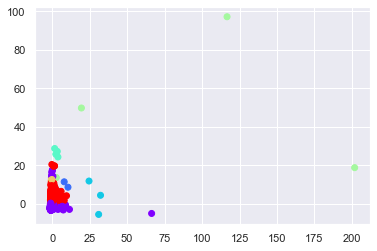

In [233]:
from sklearn.cluster import SpectralClustering

dbc = SpectralClustering(# if removing n_cluster, it will try to automatically infer best number
        assign_labels="discretize",
        random_state=SEED)
# "discretize" strategy is 100% reproducible, but tends to create parcels of fairly even and geometrical shape

predicted=dbc.fit_predict(transformed_flag_no_flag)

# Plot dataset with clusters
plt.scatter(transformed_flag_no_flag[0],transformed_flag_no_flag[1],c=predicted, cmap='rainbow')

In [234]:
len(pd.Series(predicted).unique())

7

# DBSCAN

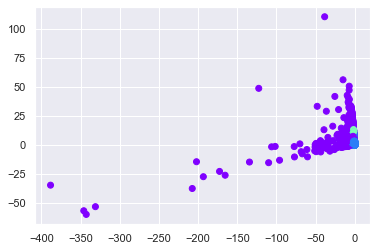

In [235]:
from sklearn.cluster import DBSCAN

# define the model
#model = DBSCAN() # using default values eps=0.5, min_samples=5...
model= DBSCAN(eps=0.90, min_samples=10)# alternative

predicted=model.fit_predict(Z)

# Plot dataset with clusters
plt.scatter(Z[0],Z[1],c=predicted, cmap='rainbow')

In [236]:
print(predicted)
predicted = pd.DataFrame(predicted)

[0 0 0 ... 0 0 0]


In [237]:
Z_db = np.concatenate([Z, predicted], axis=1)
Z_db = pd.DataFrame(Z_db)
Z_db.columns = [0,1,2,3,4,'cluster']

In [238]:
Z_db = Z_db[Z_db.cluster != -1] # we drop observations that are noise

In [239]:
Z_db.head()

,0,1,2,3,4,cluster
0,-1.368005,2.078462,-1.418680,-3.370455,0.725825,0.0
1,-1.053785,0.794664,-0.223040,-0.725517,0.155901,0.0
2,-1.897780,1.708334,-2.313907,0.634208,1.204102,0.0
4,-1.287072,2.586002,1.135236,0.918652,0.212668,0.0
5,-0.436768,0.321578,-0.089806,-0.078949,0.129232,0.0


In [240]:
Z_db.shape # we removed 16573-11089 = 5,484 noise observations

(13101, 6)

In [241]:
print(len(pd.unique(Z_db['cluster'])))

6


0.0    12990
2.0       63
1.0       25
4.0       10
5.0        7
3.0        6
Name: cluster, dtype: int64


<AxesSubplot:>

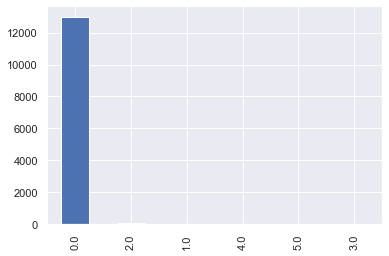

In [242]:
print(Z_db.cluster.value_counts())
Z_db.cluster.value_counts().plot(kind="bar")

As we can observe, most observations are lumped into one cluster.

# OPTICS

According to the sklearn documentation, "OPTICS (Ordering Points To Identify the Clustering Structure), closely related to DBSCAN, finds core sample of high density and expands clusters from them. Unlike DBSCAN, keeps cluster hierarchy for a variable neighborhood radius. Better suited for usage on large datasets than the current sklearn implementation of DBSCAN."

In [243]:
from sklearn.cluster import OPTICS

clustering = OPTICS(min_samples=2).fit(Z)
cluster_optics = clustering.labels_

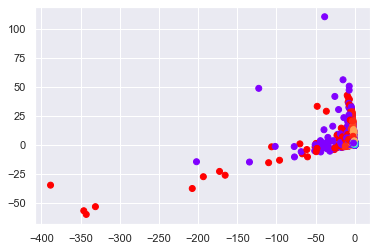

In [244]:
plt.scatter(Z[0],Z[1],c=cluster_optics ,cmap='rainbow')

In [245]:
len(pd.Series(cluster_optics).unique())

3725

# BIRCH

Balanced Iterative Reducing and Clustering using Hierarchies

According to the sklearn website, "BIRCH does not scale very well to high dimensional data. As a rule of thumb if n_features is greater than twenty, it is generally better to use MiniBatchKMeans."

"If the number of instances of data needs to be reduced, or if one wants a large number of subclusters either as a preprocessing step or otherwise, BIRCH is more useful than MiniBatchKMeans."

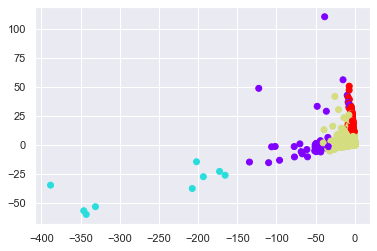

In [246]:
from sklearn.cluster import Birch

birch_model = Birch(branching_factor=100,threshold=0.5,n_clusters=4)
birch_model.fit(Z)

Birch(branching_factor=100, compute_labels=True, copy=True, n_clusters=4,
      threshold=0.5)
y_clus_bch = birch_model.predict(Z)
plt.scatter(Z[0],Z[1],c=birch_model.labels_,cmap='rainbow')

In [247]:
len(pd.Series(y_clus_bch).unique())

4

# Final thoughts

In conclusion, which clustering method we are to use depends on many factors such as the geometry metric to be used one prefers, the dimensionality of the data, computation time concerns, whether one wants high number of clusters or not whether one want to filter out noise or not, etc. The number of cluters may differ siginificantly based on different clustering methods. 

Further, SVD and PCA are truly helpful in lessening computational time and improving data visualization. However, since the values are not directly interpretable, it is difficult for me to interpret the clusters I've made. Adding clusters to the dataframe do not improve the performance of my classification models.

From our clustering from K-means ealier, we calculate the proprotion of who died per cluster.

In [267]:
# k=2

#fitting the model
SEED=2305
km = KMeans(n_clusters=2)
y_predicted = km.fit_predict(transformed)
y_predicted

array([0, 0, 0, ..., 0, 0, 0])

In [268]:
prob_death_df_1 = pd.concat([response['HOSPITAL_EXPIRE_FLAG'], pd.DataFrame(y_predicted)], axis=1)

In [269]:
prob_death_df_1.columns = ['HOSPITAL_EXPIRE_FLAG', 'cluster']

In [270]:
prob_death_df_1.head()

,HOSPITAL_EXPIRE_FLAG,cluster
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


<AxesSubplot:xlabel='cluster', ylabel='HOSPITAL_EXPIRE_FLAG'>

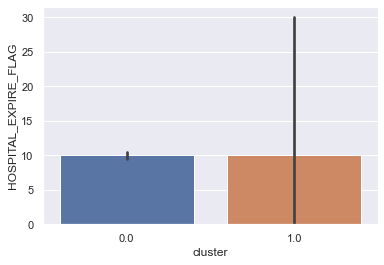

In [275]:
sns.barplot(x='cluster', y='HOSPITAL_EXPIRE_FLAG', data=prob_death_df_1, estimator=lambda x: sum(x==1)*100.0/len(x))

Same chances of dying whether one belongs to cluster 0 or 1.

Let's try one more time from the clusters we got from agglomerative clustering.

In [272]:
hc = AgglomerativeClustering( affinity = 'euclidean', linkage ='ward', distance_threshold=70, n_clusters=None)

predicted=hc.fit_predict(transformed_flag_no_flag)

prob_death_df_2 = pd.concat([transformed_flag['HOSPITAL_EXPIRE_FLAG'], pd.DataFrame(y_predicted)], axis=1)

In [273]:
prob_death_df_2.columns = ['HOSPITAL_EXPIRE_FLAG', 'cluster']

<AxesSubplot:xlabel='cluster', ylabel='HOSPITAL_EXPIRE_FLAG'>

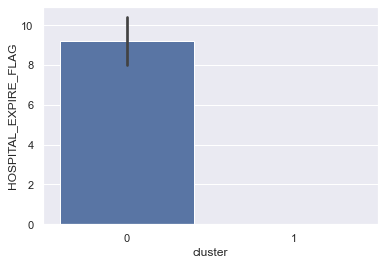

In [276]:
sns.barplot(x='cluster', y='HOSPITAL_EXPIRE_FLAG', data=prob_death_df_2, estimator=lambda x: sum(x==1)*100.0/len(x))

For what we got from agglomerative clustering, if one belonged to cluster 1, it is very likely that he/she did not die.